In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score
import mord

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

## PyTorch

In [6]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 1.7.1+cu110
True


In [7]:
if False:
    PATH='enet_b2_8.pt'
    #PATH='enet_b2_7.pt'
    IMG_SIZE=260 #224 #
else:
    #PATH='enet_b0_8_best_afew.pt'
    PATH='enet_b0_8_best_vgaf.pt'
    
    #PATH='enet_b0_8_va_mtl.pt'
    IMG_SIZE=224
    
#IMG_SIZE=112

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
np_transforms = transforms.Compose(
    [
        transforms.ToPILImage(None),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)


In [22]:
print(PATH)
feature_extractor_model = torch.load('../../models/affectnet_emotions/'+PATH)

enet_b0_8_best_vgaf.pt


In [8]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(10, 1280) [[ 0.00679121  0.09001139  0.0694934  ...  0.10351563 -0.00995514
  -0.17376047]
 [-0.004085   -0.07134113 -0.12164655 ... -0.05029012  0.03059323
   0.08198261]
 [-0.0034241  -0.06510569 -0.00448079 ...  0.04248156 -0.10535879
  -0.00544419]
 ...
 [ 0.07878461 -0.03540913 -0.06665969 ... -0.10314589  0.1332206
  -0.06119434]
 [-0.02409821 -0.00270485  0.00887998 ... -0.00501176  0.01345664
  -0.02131553]
 [-0.04529824 -0.04590099 -0.00950194 ...  0.00753843  0.02128105
  -0.05743075]]
(10,) [-0.03629377 -0.00268708 -0.05411524  0.01482256  0.13788255  0.09921926
 -0.05259513 -0.0124341   0.0816549   0.04621203]


In [9]:
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [79]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

## Aligned

In [12]:
print(test_transforms)
img_names=[]
X_global_features=[]
imgs=[]
for d in ['cropped_aligned','cropped_aligned_new_50_vids']:
    data_dir=os.path.join(DATA_DIR,'cropped_aligned',d)
    print(data_dir)
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)   
        if not os.path.isdir(frames_dir):
            continue
        for img_name in os.listdir(frames_dir):
            if img_name.lower().endswith('.jpg'):
                img = Image.open(os.path.join(frames_dir,img_name))
                img_tensor = test_transforms(img)
                if img.size:
                    img_names.append(filename+'/'+img_name)
                    imgs.append(img_tensor)
                    if len(imgs)>=64: #96: #48: #32:        
                        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features=features.data.cpu().numpy()
                        #print(features.shape)

                        if len(X_global_features)==0:
                            X_global_features=features
                        else:
                            X_global_features=np.concatenate((X_global_features,features),axis=0)
                        imgs=[]

if len(imgs)>0:        
    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
    features=features.data.cpu().numpy()

    if len(X_global_features)==0:
        X_global_features=features
    else:
        X_global_features=np.concatenate((X_global_features,features),axis=0)

    imgs=[]

    #X_scores=X_global_features #get_probab(X_global_features)
    #print(X_global_features.shape,X_scores.shape)

Compose(
    Resize(size=(112, 112), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER/cropped_aligned/cropped_aligned


  0%|          | 0/564 [00:00<?, ?it/s]

/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER/cropped_aligned/cropped_aligned_new_50_vids


  0%|          | 0/31 [00:00<?, ?it/s]

In [26]:
for filename in tqdm(os.listdir(data_dir)[8:]):
    frames_dir=os.path.join(data_dir,filename)   
    if not os.path.isdir(frames_dir):
        continue
    for img_name in os.listdir(frames_dir):
        if img_name.lower().endswith('.jpg'):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                img_names.append(filename+'/'+img_name)
                imgs.append(img_tensor)
                if len(imgs)>=96: #64: #48: #32:        
                    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    features=features.data.cpu().numpy()
                    #print(features.shape)

                    if len(X_global_features)==0:
                        X_global_features=features
                    else:
                        X_global_features=np.concatenate((X_global_features,features),axis=0)
                    imgs=[]

if len(imgs)>0:        
    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
    features=features.data.cpu().numpy()

    if len(X_global_features)==0:
        X_global_features=features
    else:
        X_global_features=np.concatenate((X_global_features,features),axis=0)

    imgs=[]

  0%|          | 0/23 [00:00<?, ?it/s]

## Cropped

In [11]:
DATA_DIR

'/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER'

In [12]:
print(test_transforms)
img_names=[]
X_global_features=[]
imgs=[]
data_dir=os.path.join(DATA_DIR,'cropped')
print(data_dir)
for filename in tqdm(os.listdir(data_dir)):
    frames_dir=os.path.join(data_dir,filename)   
    if not os.path.isdir(frames_dir):
        continue
    for img_name in os.listdir(frames_dir):
        if img_name.lower().endswith('.jpg'):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                img_names.append(filename+'/'+img_name)
                imgs.append(img_tensor)
                if len(imgs)>=64: #96: #48: #32:        
                    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    features=features.data.cpu().numpy()
                    #print(features.shape)

                    if len(X_global_features)==0:
                        X_global_features=features
                    else:
                        X_global_features=np.concatenate((X_global_features,features),axis=0)
                    imgs=[]

if len(imgs)>0:        
    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
    features=features.data.cpu().numpy()

    if len(X_global_features)==0:
        X_global_features=features
    else:
        X_global_features=np.concatenate((X_global_features,features),axis=0)

    imgs=[]

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER/cropped


  0%|          | 0/594 [00:00<?, ?it/s]

----------------------------------

In [13]:
X_scores=get_probab(X_global_features)

In [14]:
X_scores.shape,X_global_features.shape

((2942996, 10), (2942996, 1280))

In [15]:
filename2featuresAll={img_name:(global_features,scores) for img_name,global_features,scores in zip(img_names,X_global_features,X_scores)}
#filename2featuresAll={img_name:(global_features,) for img_name,global_features, in zip(img_names,X_global_features)}
print(len(filename2featuresAll))
#cropped 2942996, aligned 2941546

2942996


### Save/load features 

In [6]:
import pickle
num_classes=8
model_name='enet_b0_8_best_vgaf' #first three challenges

#model_name='enet_b0_8_va_mtl'

#MODEL2FEATURES=model_name+'_aligned_112.pickle'
MODEL2FEATURES=model_name+'_cropped.pickle' 

print(MODEL2FEATURES)

enet_b0_8_best_vgaf_cropped.pickle


In [17]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump(filename2featuresAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open(MODEL2FEATURES, 'rb') as handle:
    filename2featuresAll=pickle.load(handle)
print(len(filename2featuresAll))

2942996


# Classifiers

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
import efficientnet.tfkeras as enet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.4.1


In [9]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [10]:
def one_hot_transfer(label,class_num):
    return np.eye(class_num)[label]

def metric_for_Exp(gt,pred,class_num=8):
    # compute_acc
    acc = accuracy_score(gt,pred)
    # compute_F1
    gt = one_hot_transfer(gt,class_num)
    pred = one_hot_transfer(pred,class_num)
    F1 = []
    for i in range(class_num):
        gt_ = gt[:,i]
        pred_ = pred[:,i]
        F1.append(f1_score(gt_.flatten(), pred_))
    F1_mean = np.mean(F1)
    return F1_mean,acc,F1

In [11]:
def CCC_score(x, y):
    vx = x - np.mean(x)
    vy = y - np.mean(y)
    rho = np.sum(vx * vy) / (np.sqrt(np.sum(vx**2)) * np.sqrt(np.sum(vy**2)))
    x_m = np.mean(x)
    y_m = np.mean(y)
    x_s = np.std(x)
    y_s = np.std(y)
    ccc = 2*rho*x_s*y_s/(x_s**2 + y_s**2 + (x_m - y_m)**2)
    return ccc

def metric_for_VA(gt_V,gt_A,pred_V,pred_A):
    ccc_V,ccc_A = CCC_score(gt_V,pred_V),CCC_score(gt_A,pred_A)
    return ccc_V,ccc_A, 0.5*(ccc_V+ccc_A)

def CCC_numpy(y_true, y_pred):
    '''Reference numpy implementation of Lin's Concordance correlation coefficient'''
    
    # covariance between y_true and y_pred
    s_xy = np.cov([y_true, y_pred])[0,1]
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2+K.epsilon())
    #print(s_xy,s_x_sq,s_y_sq,x_m,y_m)
    return ccc

def CCC_VA(y_true, y_pred):
    return 1-0.5*(CCC(y_true[:,0], y_pred[:,0])+CCC(y_true[:,1], y_pred[:,1]))


In [12]:
import math
def f1_score_max_for_AU_one_class(gt, pred, thresh,type=0):
    gt = gt[:,type]
    pred = pred[:,type]
    P = []
    R = []
    ACC = []
    F1 = []
    for i in thresh:
        new_pred = ((pred >= i) * 1).flatten()
        P.append(precision_score(gt.flatten(), new_pred))
        R.append(recall_score(gt.flatten(), new_pred))
        ACC.append(accuracy_score(gt.flatten(), new_pred))
        F1.append(f1_score(gt.flatten(), new_pred))

    F1_MAX = max(F1)
    if F1_MAX < 0 or math.isnan(F1_MAX):
        F1_MAX = 0
        F1_THRESH = 0
        accuracy = 0
    else:
        idx_thresh = np.argmax(F1)
        F1_THRESH = thresh[idx_thresh]
        accuracy = ACC[idx_thresh]
    return F1,F1_MAX,F1_THRESH,accuracy

def f1_score_max(gt, pred, thresh,c=12):
    F1_s = []
    F1_t = []
    ACC = []
    from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
    for i in range(c):
        F1, F1_MAX, F1_THRESH,acc = f1_score_max_for_AU_one_class(gt,pred,thresh,i)
        F1_s.append(F1_MAX)
        F1_t.append(F1_THRESH)
        ACC.append(acc)
    F1_s=np.array(F1_s)
    F1_t=np.array(F1_t)
    ACC=np.array(ACC)
    return F1_s.mean(),F1_t.mean(),F1_s,F1_t,ACC

## Expr 

In [14]:
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
print('AffectNet:',class_to_idx)

#idx_to_class_2={0: 'Neutral', 1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised', 7:'Other'} #ABAW
#idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprised'} #AffectNet
AFFECTNET2MTL=np.array([5,0,2,3,4,6,7,1])
print(AFFECTNET2MTL)

AffectNet: {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
[5 0 2 3 4 6 7 1]


In [15]:
def get_image2Expr(dirname):
    dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    minConstantFrames,numConstant=100000,0
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                prev_val=None
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            if prev_val is None:
                                prev_val=expression
                                numConstant=1
                            elif prev_val==expression:
                                numConstant+=1
                            else:
                                if numConstant<minConstantFrames:
                                    minConstantFrames=numConstant
                                prev_val=expression
                                numConstant=1
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][0])
                                #X.append(filename2featuresAll[imagename][1])
                                y.append(expression)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed,minConstantFrames)
    return X,y

X_train,y_train=get_image2Expr('Train_Set')
X_val,y_val=get_image2Expr('Validation_Set')
TRAIN_VAL=False
#cropped: (585317, 1280) (585317,) 12044 1
#(280532, 1280) (280532,) 3698 3

#aligned: (586959, 1280) (586959,) 10402 1
#(279749, 1280) (279749,) 4481 3

(585317, 1280) (585317,) 12044 1
(280532, 1280) (280532,) 3698 3


In [42]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(1146381, 1280) (1146381,)


In [16]:
def print_expr():
    y_val_preds=mlpModel.predict(X_val)
    y_pred=np.argmax(y_val_preds,axis=1)
    print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))
    print(metric_for_Exp(y_val,y_pred))

In [43]:
(unique, counts) = np.unique(y_train, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print(np.unique(y_val, return_counts=True))

[341714  28825  21363  25896 164485 129065  56279 378754] {0: 1.1083947394604845, 1: 13.139774501300954, 2: 17.72943874923934, 3: 14.625965400061785, 4: 2.3026658965863147, 5: 2.9345988455429435, 6: 6.729934789175358, 7: 1.0} 8 [0 1 2 3 4 5 6 7]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 82258,   6126,   5296,   8408,  34511,  25157,  12332, 106444]))


In [44]:
batch_size=256 #128
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='softmax',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_train.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(num_classes,activation='softmax'))

In [45]:
mlpModel.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlpModel.summary()

save_best_model = SaveBestModel('val_accuracy',True)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 10, verbose=1, 
             callbacks=[save_best_model], validation_data=(X_val,y_val),class_weight=class_weights)
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 165,000
Trainable params: 165,000
Non-trainable params: 0
_________________________________________________________________
4479/4479 [==============================] - 19s 4ms/step - loss: 1.4780 - accuracy: 0.7774 - val_loss: 0.2638 - val_accuracy: 0.9082
0.9082100987434387


In [90]:
if True:
    print_expr()
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
print_expr()

Acc: 0.44149687023227296 F1: 0.33779997894441405
(0.33779997894441405, 0.44149687023227296, [0.4416201062812616, 0.15014895729890765, 0.4473529411764706, 0.03736895502198174, 0.44162295893122216, 0.4805736532655331, 0.1928639673178928, 0.5108482922620425])
Best weights:
Acc: 0.4512782855431822 F1: 0.32977590239234855
(0.32977590239234855, 0.4512782855431822, [0.5265049308722749, 0.136551724137931, 0.23451630063074705, 0.034811438043928715, 0.5094281502343286, 0.5118863619636418, 0.22221146632462913, 0.4622968469313074])


In [19]:
if False:
    mlpModel.save_weights('expr_enet0_vgaf.h5')#Acc: 0.49544436998274705 F1: 0.3844313672414089
else:
    #mlpModel.load_weights('../expr_enet0_vgaf.h5') #Acc: 0.500285172458044 F1: 0.3807067519117502
    mlpModel.load_weights('expr_enet0_vgaf.h5') #Acc: 0.49544436998274705 F1: 0.3844313672414089
    print_expr()

Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])


In [19]:
mlpModel.load_weights('expr_enet0_vgaf.h5')
y_val_preds=mlpModel.predict(X_val)
y_pred=np.argmax(y_val_preds,axis=1)
print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))
print(metric_for_Exp(y_val,y_pred))

Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])


(280532,) (280532,) 0.49544436998274705


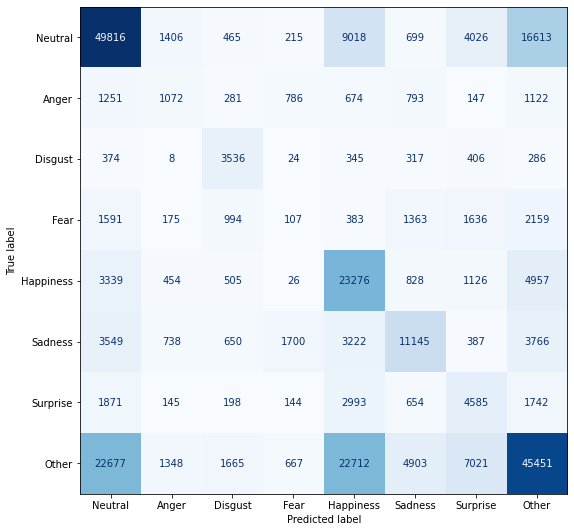

In [18]:
labels=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise','Other']
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False,values_format='d') #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_pred,labels)

enet_b0_8_best_vgaf
aligned
112
Acc: 0.36997808749986594 F1: 0.21352704404593095
(0.21352704404593095, 0.36997808749986594, [0.45700583162587527, 0.07635619242579324, 0.003076194983435873, 0.009468317552804079, 0.34928095010272137, 0.21187660892709106, 0.1647308567096285, 0.4364214000400981])

../expr_enet0_vgaf.h5
Acc: 0.20843684874655494 F1: 0.0910746772554131


224
Acc: 0.47395701146384794 F1: 0.3045351324629094
(0.3045351324629094, 0.47395701146384794, [0.5518323928131282, 0.11104639875752281, 0.028970239662891757, 0.029782898346265387, 0.42825757737346165, 0.5113845517526626, 0.2515561703388993, 0.5234508306584433])

../expr_enet0_vgaf.h5
Acc: 0.42862351608048643 F1: 0.3395506137533413


cropped
Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])
../expr_enet0_vgaf.h5
Acc: 0.500285172458044 F1: 0.3807067519117502
(0.3807067519117502, 0.500285172458044, [0.608643679809698, 0.15128569174948728, 0.5162256615077384, 0.01599360255897641, 0.4778312968664514, 0.4611138100075078, 0.3029224246739377, 0.5116378481202044])


enet_b0_8_va_mtl
aligned
112
Acc: 0.36310406828978836 F1: 0.21416588541497295
(0.21416588541497295, 0.36310406828978836, [0.5104795189391993, 0.1258546760922471, 0.010939722131057872, 0.009548019096038193, 0.33523095946425735, 0.18541315145321896, 0.19094959313671342, 0.3449114430070513])

../expr_enet0_vgaf.h5
Acc: 0.17444566379147022 F1: 0.09599142979803564


224


cropped
Acc: 0.44668344431294826 F1: 0.3355545672821115
(0.3355545672821115, 0.44668344431294826, [0.510145234564414, 0.16641097373883224, 0.3162162162162162, 0.0352055352055352, 0.5013185136754931, 0.4799950349621416, 0.2053190850693402, 0.4698259448249195])
../expr_enet0_vgaf.h5
Acc: 0.4230711647869049 F1: 0.30920724751192785

#### Fine-tuning 

In [23]:
w0,b0=mlpModel.layers[0].get_weights()
print(w0.shape,b0.shape)

with torch.no_grad():
    l0=nn.Linear(X_train.shape[1],num_classes)
    l0.weight.copy_(torch.from_numpy(np.transpose(w0)).float())
    l0.bias.copy_(torch.from_numpy(b0).float())
model=feature_extractor_model
model.classifier=l0
model=model.to(device)
print(model)

(1280, 8) (8,)
EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
   

In [20]:
#FINETUNED_PATH='enet_b0_vgaf_finetuned_logreg_expr.pt'
FINETUNED_PATH='enet_b0_vgaf_finetuned_expr.pt'

---------------------

In [20]:
w0,b0=mlpModel.layers[0].get_weights()
print(w0.shape,b0.shape)

w1,b1=mlpModel.layers[1].get_weights()
print(w1.shape,b1.shape)

with torch.no_grad():
    l0=nn.Linear(X_train.shape[1],128)
    l0.weight.copy_(torch.from_numpy(np.transpose(w0)).float())
    l0.bias.copy_(torch.from_numpy(b0).float())
    l1=nn.Linear(128,num_classes)
    l1.weight.copy_(torch.from_numpy(np.transpose(w1)).float())
    l1.bias.copy_(torch.from_numpy(b1).float())
model=feature_extractor_model
model.classifier=nn.Sequential(l0,
          nn.ReLU(),
          l1)
model=model.to(device)
print(model)

(1280, 128) (128,)
(128, 8) (8,)
EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): B

In [8]:
FINETUNED_PATH='enet_b0_vgaf_finetuned_2layers_expr.pt'

--------------

In [22]:
if False:
    torch.save(model, FINETUNED_PATH)
else:
    print(FINETUNED_PATH)
    model = torch.load(FINETUNED_PATH)

enet_b0_vgaf_finetuned_expr.pt


In [21]:
data_dir=os.path.join(DATA_DIR,'cropped')
print(data_dir)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER/cropped


In [36]:
def get_filename2Expr(dirname,step=1):
    dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    numConstant=0
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                prev_val=None
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            if prev_val is None:
                                prev_val=expression
                                numConstant=1
                            elif prev_val==expression:
                                numConstant+=1
                            else:
                                prev_val=expression
                                numConstant=1
                            if i%step!=step-1:
                                continue
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if os.path.exists(os.path.join(data_dir,imagename)):
                                X.append(imagename)
                                y.append(expression)
                            else:
                                num_missed+=1
    y=np.array(y)
    print(len(X),y.shape,num_missed)
    return X,y


In [11]:
filenames_train,y_train=get_filename2Expr('Train_Set',1)
filenames_val,y_val=get_filename2Expr('Validation_Set',5)

585317 (585317,) 12044
56087 (56087,) 729


In [133]:
from torch.utils import data
class ABAW2_Exp_data_img(data.dataset.Dataset):
    def __init__(self,filenames,y,transform):
        self.transform=transform
        self.filenames=filenames
        self.y=y
    
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        img = Image.open(os.path.join(data_dir, self.filenames[index]))
        img = self.transform(img)
        return img,self.y[index]

train_transforms = transforms.Compose(
    [
        #transforms.Resize((IMG_SIZE_ORIG,IMG_SIZE_ORIG)),
        #transforms.RandomResizedCrop(IMG_SIZE),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

batch_size=64
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_dataset = ABAW2_Exp_data_img(filenames_train,y_train,train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = ABAW2_Exp_data_img(filenames_val,y_val,test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

NameError: name 'transforms' is not defined

In [13]:
(unique, counts) = np.unique(y_train, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
num_classes=len(unique)
print(num_classes,counts, class_weights.values())

8 [177198  16573  10771   9080  95463  78751  31615 165866] dict_values([1.0, 10.691968865021419, 16.451397270448425, 19.515198237885464, 1.856195594104522, 2.2501047605744686, 5.6048711054879, 1.0683202102902343])


In [14]:
""" Label smooth """
def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # convert to one-hot
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    #logsoftmax = nn.LogSoftmax(dim=-1)
    return torch.mean(torch.sum(- weights*soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1)) #num_classes) #
    return cross_entropy_loss_with_soft_target(pred, soft_target)


In [15]:
# loss function
weights = torch.FloatTensor(list(class_weights.values())).cuda()
if False:
    criterion = nn.CrossEntropyLoss(weight=weights)
    #criterion = nn.CrossEntropyLoss()
else:
    criterion=cross_entropy_with_label_smoothing

In [16]:
def test(model):
    model.eval()
    with torch.no_grad():
        labels,preds=[],[]
        epoch_val_accuracy,epoch_val_f1=0,0
        for data, label in test_loader:
            data = data.to(device)
            #label = label.to(device)

            val_output = model(data)
            val_preds=val_output.argmax(dim=1).cpu()
            
            labels.extend(label)
            preds.extend(val_preds)

    labels=np.array(labels)
    preds=np.array(preds)
    epoch_val_accuracy = (preds == labels).mean()
    epoch_val_f1=f1_score(y_true=labels,y_pred=preds, average="macro")
    return epoch_val_accuracy,epoch_val_f1

test(model) #(0.39825628042148803, 0.2818708210857309)

(0.41608572396455507, 0.2999480217211319)

In [17]:
import sys
sys.path.append('../affectnet')
from robust_optimization import RobustOptimizer
import copy
def train(model,n_epochs, learningrate, use_sam=False, optimizer=optim.Adam, need_train_acc=True):
    # optimizer
    if use_sam:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optimizer, lr=learningrate)
    else:
        optimizer=optimizer(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_f1=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            if use_sam:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if need_train_acc:
                acc = (output.argmax(dim=1) == label).float().sum()
                epoch_accuracy += acc / len(train_dataset)
            epoch_loss += loss / len(train_loader)

        epoch_val_accuracy,epoch_val_f1=test(model)
        if need_train_acc:
            print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_f1: {epoch_val_f1:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        else:
            print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_f1: {epoch_val_f1:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        if best_f1<epoch_val_f1:
            best_f1=epoch_val_f1
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best f1:{best_f1}")
        epoch_val_accuracy,epoch_val_f1=test(model)
        print(
            f"val_f1: {epoch_val_f1:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")

In [18]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad
set_parameter_requires_grad(model, requires_grad=True)

In [19]:
train(model,5,1e-4,use_sam=True)
#Epoch : 5 - loss : 2.5206 - acc: 0.9855 - val_f1: 0.3805 - val_acc: 0.4829

  0%|          | 0/9146 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch : 3 - loss : 2.5846 - acc: 0.9725 - val_f1: 0.3553 - val_acc: 0.4595



  0%|          | 0/9146 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch : 5 - loss : 2.5213 - acc: 0.9853 - val_f1: 0.3565 - val_acc: 0.4713

Best f1:0.37740892891459465
val_f1: 0.3774 - val_acc: 0.4903



In [23]:
if False:
    torch.save(model, FINETUNED_PATH)
else:
    print(FINETUNED_PATH)
    model = torch.load(FINETUNED_PATH)

enet_b0_vgaf_finetuned_expr.pt


In [37]:
#model.eval()
filenames_val_all,y_val_all=get_filename2Expr('Validation_Set',1)
val_scores=[]
imgs=[]
for filename in tqdm(filenames_val_all):
    filepath=os.path.join(data_dir,filename)   
    img = Image.open(filepath)
    img_tensor = test_transforms(img)
    if img.size:
        imgs.append(img_tensor)
        if len(imgs)>=64: #96: #48: #32:        
            scores = model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            #preds=np.argmax(scores,axis=1)
            #print(scores.shape,preds.shape)

            if len(val_scores)==0:
                val_scores=scores
            else:
                val_scores=np.concatenate((val_scores,scores),axis=0)
            imgs=[]

if len(imgs)>0:        
    scores = model(torch.stack(imgs, dim=0).to(device))
    scores=scores.data.cpu().numpy()
    #preds=np.argmax(scores,axis=1)
    #print(scores.shape,preds.shape)

    if len(val_scores)==0:
        val_scores=scores
    else:
        val_scores=np.concatenate((val_scores,scores),axis=0)
    imgs=[]


280532 (280532,) 3698


  0%|          | 0/280532 [00:00<?, ?it/s]

In [38]:
val_preds=np.argmax(val_scores,axis=1)
acc= (val_preds == y_val_all).mean()
f1=f1_score(y_true=y_val_all,y_pred=val_preds, average="macro")
print(acc,f1)
print(metric_for_Exp(y_val,val_preds))
#first model 0.4836667474655298 0.3801234273402112
#2 layers:0.4426197367858212 0.3418797148135464
#1layer and bias:

0.4836667474655298 0.3801234273402112
(0.3801234273402112, 0.4836667474655298, [0.580467222914545, 0.2462413652986591, 0.47159423685135293, 0.05278283748229103, 0.5092937576754157, 0.4012854191639675, 0.2608122114388015, 0.5185103678966566])


In [41]:
print(metric_for_Exp(y_val,val_preds)) #logreg

(0.37755217409013575, 0.48992271826387007, [0.565062109777239, 0.2572753280063135, 0.4055436081242533, 0.054577097111033764, 0.5136565742113064, 0.41232826235721426, 0.25534346014249226, 0.5566309529912339])


##### Ensemble 

In [39]:
#y_val_preds=mlpModel.predict(X_val)
y_pred=np.argmax(y_val_preds,axis=1)
print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))
print(metric_for_Exp(y_val,y_pred))

Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])


In [40]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*val_scores
    y_ensemble_pred=np.argmax(y_ensemble,axis=1)
    print(w,metric_for_Exp(y_val,y_ensemble_pred))

0.0 (0.3801234273402112, 0.4836667474655298, [0.580467222914545, 0.2462413652986591, 0.47159423685135293, 0.05278283748229103, 0.5092937576754157, 0.4012854191639675, 0.2608122114388015, 0.5185103678966566])
0.1 (0.3827371740485952, 0.487245661813982, [0.5854303801455072, 0.24899334374229598, 0.4796374694412974, 0.05061279123269335, 0.5097745922925105, 0.4046989422294548, 0.2619399930737021, 0.5208098802313003])
0.2 (0.3848571300247635, 0.4908851753097686, [0.5909438312054427, 0.25137522920486743, 0.4864209505334627, 0.04656435298221137, 0.5097381070777391, 0.40697143437008476, 0.26393406385195944, 0.5229090709723402])
0.30000000000000004 (0.3877536218010715, 0.4955584389659647, [0.5974731152665433, 0.25398710553104853, 0.4949894841024372, 0.04293495674463313, 0.5098946498657302, 0.4096733350215244, 0.26678473166566524, 0.5262915962109895])
0.4 (0.3904217485408135, 0.5004206293756149, [0.6047069590274428, 0.2561782109293421, 0.5042567951062622, 0.035819739580812235, 0.5105966876987843,

In [55]:
if False:
    y_pred_new=y_pred.copy()
else:
    w=0.8
    y_ensemble=w*y_val_preds+(1-w)*val_scores
    y_pred_new=np.argmax(y_ensemble,axis=1)
y_preds_other_inds=y_pred_new!=7
for w in np.linspace(0,1,11):
    y_ensemble=w*y_scores_all+(1-w)*y_val_preds
    y_ensemble_pred=np.argmax(y_ensemble,axis=1)
    y_pred_new[y_preds_other_inds]=y_ensemble_pred[y_preds_other_inds]
    print(w,metric_for_Exp(y_val,y_pred_new))

0.0 (0.3952488491649343, 0.517563058759785, [0.6016788248226242, 0.1918739931984965, 0.5253380888690742, 0.016344229486324215, 0.48850525596102906, 0.49619380261508145, 0.2903130634322242, 0.5517435349346206])
0.1 (0.40953213649205417, 0.5274407197752841, [0.6148188421290555, 0.17785527462946818, 0.5444070332959222, 0.017477562588568727, 0.5067708555124983, 0.5583590338004264, 0.3141117359331847, 0.5424567540473093])
0.2 (0.4074720160149119, 0.5272410990546533, [0.6116878860768102, 0.13929040735873852, 0.5155406391361447, 0.03301680058436816, 0.5130563701884057, 0.5855199682173329, 0.3228455116263024, 0.5388185449311923])
0.30000000000000004 (0.3953708890368174, 0.5149002609327991, [0.5876591201161074, 0.11233642111454196, 0.4490543014032947, 0.06676266527032335, 0.5096215030170049, 0.5766154717248213, 0.32346439572386304, 0.5374532339245822])
0.4 (0.37880367622786354, 0.49849927993954346, [0.5566701701635113, 0.09710902124695228, 0.3909755322529393, 0.07857573928786964, 0.499264876576

In [64]:
if True: #0.6000000000000001 0.30000000000000004 0.41613799562599263
    y_pred_new=y_pred.copy()
else: #0.6000000000000001 0.2 0.418041991345558
    w=0.8
    y_ensemble=w*y_val_preds+(1-w)*val_scores
    y_pred_new=np.argmax(y_ensemble,axis=1)
y_preds_other_inds=y_pred_new!=7

best_f1=0
best_w1,best_w2=0,0
for w1 in np.linspace(0,1,11):
    for w2 in np.arange(0,1.05-w1,0.1):
        y_ensemble=w1*y_val_preds+w2*val_scores+(1-w1-w2)*y_scores_all
        y_ensemble_pred=np.argmax(y_ensemble,axis=1)
        y_pred_new[y_preds_other_inds]=y_ensemble_pred[y_preds_other_inds]
        f1,acc,_=metric_for_Exp(y_val,y_pred_new)
        print(w1,w2,f1,acc)
        if best_f1<f1:
            best_f1=f1
            best_w1,best_w2=w1,w2

print(best_w1,best_w2,best_f1)

0.0 0.0 0.31628854771760845 0.42296422511513837
0.0 0.1 0.33351319443379285 0.43878773188085496
0.0 0.2 0.35001497045027763 0.45577688106882636
0.0 0.30000000000000004 0.36505587960731756 0.4720174525544323
0.0 0.4 0.3781678458913733 0.4860764547360016
0.0 0.5 0.387350397497928 0.49730868492720975
0.0 0.6000000000000001 0.3929559903501187 0.5055394749975047
0.0 0.7000000000000001 0.39871138770705294 0.5128185019890779
0.0 0.8 0.3981373406751429 0.5147327221136982
0.0 0.9 0.3975421585544657 0.5150749290633511
0.0 1.0 0.3934100528686891 0.5109256697988108
0.1 0.0 0.3212405732052011 0.4277622517217287
0.1 0.1 0.3399231588671779 0.4456140475952832
0.1 0.2 0.35757414961998873 0.46411104615516235
0.1 0.30000000000000004 0.37418430652299184 0.48159211783325967
0.1 0.4 0.385944677637158 0.4950344345743088
0.1 0.5 0.39326409457250483 0.5056072034562902
0.1 0.6000000000000001 0.39963161160788646 0.5137061012647398
0.1 0.7000000000000001 0.3999661268009579 0.5163760284031769
0.1 0.8 0.39942613517

##### Smoothing 

In [32]:
import os
dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/Validation_Set')
test_videos={}
ind=0
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,expressions,scores,cnn_preds=[],[],[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    expression=int(line)
                    if expression>=0:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            X.append(y_val_preds[ind])
                            indices.append(i)
                            expressions.append(int(line))
                            scores.append(filename2featuresAll[imagename][1][AFFECTNET2MTL])
                            cnn_preds.append(val_scores[ind])
                            ind+=1
        test_videos[fn]=(np.array(X),indices,np.array(expressions),np.array(scores),np.array(cnn_preds))
print(len(test_videos))

  0%|          | 0/70 [00:00<?, ?it/s]

70


In [40]:
delta=50
total_true=[]
total_preds=[]
weight=0.1
for videoname,(y_pred_expr,indices,expressions,scores,cnn_preds) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    
    y_pred_test_new=weight*y_pred_expr+(1-w)*cnn_preds
    y_preds_test_other_inds=np.argmax(y_pred_expr,axis=1)!=7    

    y_ensemble=weight*scores+(1-weight)*y_pred_expr
    y_pred_test_new=y_pred_expr.copy()
    y_preds_test_other_inds=np.argmax(y_pred_expr,axis=1)!=7
    y_pred_test_new[y_preds_test_other_inds]=y_ensemble[y_preds_test_other_inds]
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_test_new[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_test_new[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_test_new[cur_ind-1]+(1-w)*y_pred_test_new[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    preds=[]
    for i in range(len(preds_proba)):
        i1=max(i-delta,0)
        proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
        preds.append(np.argmax(proba))
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_preds.append(preds[ind-1])

total_true=np.array(total_true)
total_preds=np.array(total_preds)
print('Acc:',(total_preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=total_preds, average="macro"))
print(metric_for_Exp(total_true,total_preds))

Acc: 0.5462585373504627 F1: 0.431761062689951
(0.431761062689951, 0.5462585373504627, [0.6514788912381793, 0.1867602808425276, 0.5948337151433762, 0.01820367508157307, 0.5227065138189021, 0.6097208101978572, 0.34942028985507245, 0.5209643253421202])


In [42]:
delta=50
total_true=[]
total_preds=[]
weight=0.8
for videoname,(y_pred_expr,indices,expressions,scores,cnn_preds) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    
    y_pred_test_new=weight*y_pred_expr+(1-weight)*cnn_preds
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_test_new[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_test_new[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_test_new[cur_ind-1]+(1-w)*y_pred_test_new[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    preds=[]
    for i in range(len(preds_proba)):
        i1=max(i-delta,0)
        proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
        preds.append(np.argmax(proba))
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_preds.append(preds[ind-1])

total_true=np.array(total_true)
total_preds=np.array(total_preds)
print('Acc:',(total_preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=total_preds, average="macro"))
print(metric_for_Exp(total_true,total_preds))

Acc: 0.5574194744271598 F1: 0.4326929159405485
(0.4326929159405485, 0.5574194744271598, [0.68389709814856, 0.2779291553133515, 0.5947668112798264, 0.014085377154506704, 0.5126921923629709, 0.4894285642456696, 0.3112056009677065, 0.5775385280517961])


In [65]:
delta=50
total_true=[]
total_preds=[]
weight=0.8
w1,w2=0.6,0.2
for videoname,(y_pred_expr,indices,expressions,scores,cnn_preds) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    
    y_pred_test_new=weight*y_pred_expr+(1-weight)*cnn_preds
    y_preds_test_other_inds=np.argmax(y_pred_expr,axis=1)!=7
    y_ensemble=w1*y_pred_expr+w2*cnn_preds+(1-w1-w2)*scores
    y_pred_test_new[y_preds_test_other_inds]=y_ensemble[y_preds_test_other_inds]

    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_test_new[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_test_new[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_test_new[cur_ind-1]+(1-w)*y_pred_test_new[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    preds=[]
    for i in range(len(preds_proba)):
        i1=max(i-delta,0)
        proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
        preds.append(np.argmax(proba))
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_preds.append(preds[ind-1])

total_true=np.array(total_true)
total_preds=np.array(total_preds)
print('Acc:',(total_preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=total_preds, average="macro"))
print(metric_for_Exp(total_true,total_preds))

Acc: 0.5501725293371166 F1: 0.43916875305797154
(0.43916875305797154, 0.5501725293371166, [0.6782491740007602, 0.17332314160137588, 0.5830826278597915, 0.08264081255771008, 0.5324214584529572, 0.6043088998814439, 0.3384857396894877, 0.520838170420246])


### Ensemble 

#### Scores

In [104]:
dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/Validation_Set')
num_missed=0
y_scores_all,y_val=[],[]

for filename in os.listdir(dirpath):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    expression=int(line)
                    #if expression>=0:
                    if expression>=0:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            scores=filename2featuresAll[imagename][1]
                            if False:
                                scores=scores[:-2]
                            y_scores_all.append(scores[AFFECTNET2MTL])
                            y_val.append(expression)
                        else:
                            num_missed+=1
y_scores_all=np.array(y_scores_all)
y_val=np.array(y_val)
print(y_scores_all.shape,y_val.shape,num_missed)

USE_OTHER=True
if USE_OTHER:
    y_scores=np.argmax(y_scores_all,axis=1)
    print(metric_for_Exp(y_val,y_scores,8))
else:
    y_scores=np.argmax(y_scores_all[y_val!=7,:7],axis=1)
    print(metric_for_Exp(y_val[y_val!=7],y_scores,7))

(280532, 8) (280532,) 3698
(0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])


USE_OTHER=True
(280532,) (280532,) 3698
(0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])

USE_OTHER=False
(174088,) (174088,) 1883
(0.38315520007157966, 0.5219142043104636, [0.5941131445271728, 0.11673050704408232, 0.2563962686160057, 0.1146315414738341, 0.6221359518916038, 0.574566439059762, 0.40351254788859714])

(280532,) (280532,) 0.32562417121754383


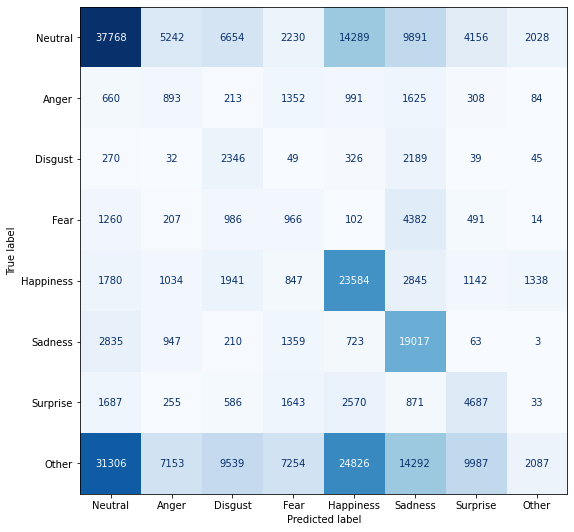

In [16]:
labels=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise','Other']
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False,values_format='d') #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_scores,labels)

In [105]:
e_x = np.exp(y_scores_all - np.max(y_scores_all,axis=0))
y_probab_all=e_x / e_x.sum(axis=1)[:,None]
print(y_probab_all)

[[0.14431557 0.04700894 0.7286932  ... 0.00801708 0.01772265 0.03276507]
 [0.12623148 0.05338586 0.74596107 ... 0.00828965 0.0161922  0.02721561]
 [0.12411553 0.05135258 0.74902546 ... 0.00888397 0.01757528 0.02525777]
 ...
 [0.61938715 0.09317015 0.15505028 ... 0.11088556 0.00744538 0.0130494 ]
 [0.4615972  0.0987     0.27191597 ... 0.15485528 0.00422211 0.00742036]
 [0.62540436 0.10433636 0.1733591  ... 0.08387769 0.00457728 0.00741982]]


In [36]:
y_scores=np.argmax(y_probab_all,axis=1)
y_max_scores=np.array([y_probab_all[i,y] for i,y in enumerate(y_scores)])

0.40469536452169447

In [39]:
for w in np.linspace(0,1,11):
    print(w,((y_max_scores<w)==(y_val==7)).mean(),((y_max_scores>=w)==(y_val==7)).mean())

0.0 0.620563785949553 0.37943621405044703
0.1 0.620563785949553 0.37943621405044703
0.2 0.620563785949553 0.37943621405044703
0.30000000000000004 0.6185319321859895 0.38146806781401055
0.4 0.5953046354783055 0.40469536452169447
0.5 0.5527497754266892 0.4472502245733107
0.6000000000000001 0.5082165314473928 0.4917834685526072
0.7000000000000001 0.47205666376741334 0.5279433362325866
0.8 0.44366418091340737 0.5563358190865926
0.9 0.4196455306346513 0.5803544693653487
1.0 0.37948255457487917 0.6205174454251209


In [42]:
for w in np.linspace(0,1,11):
    y_scores=np.argmax(y_scores_all,axis=1)
    y_scores[y_max_scores<w]=7
    print(w,metric_for_Exp(y_val,y_scores,8))

0.0 (0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])
0.1 (0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])
0.2 (0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])
0.30000000000000004 (0.2597911730430537, 0.3275526499650664, [0.47211816735363765, 0.08163451869457902, 0.16895322458679918, 0.08002747724540615, 0.4611789865547216, 0.46926102518053847, 0.2843253425698052, 0.06083064215894236])
0.4 (0.2725398854298629, 0.3382573111088931, [0.4533068150998954, 0.08461096205442699, 0.1692091312344477, 0.07889215274863619, 0

In [49]:
y_probab_sorted=np.sort(y_probab_all,axis=1)[:,6:]
diff_probab=y_probab_sorted[:,1]-y_probab_sorted[:,0]

In [53]:
for w in np.linspace(0,0.5,11):
    y_scores=np.argmax(y_scores_all,axis=1)
    y_scores[diff_probab<w]=7
    print(w,metric_for_Exp(y_val,y_scores,8))

0.0 (0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])
0.05 (0.2681231420530048, 0.33464631485891094, [0.46212387682665557, 0.07746784217372453, 0.16895322458679918, 0.07394834625441533, 0.45749439549554255, 0.4582260333979346, 0.2945822454308094, 0.15218917225815703])
0.1 (0.27388884984049766, 0.34275590663453726, [0.45001472561274913, 0.07235275851361143, 0.16895322458679918, 0.07036466358500257, 0.4508702540410587, 0.44050747365149334, 0.3046417619180373, 0.23340593681522961])
0.15000000000000002 (0.27592473960131664, 0.34920436884205724, [0.43565206887758523, 0.06796116504854369, 0.1694596937301358, 0.06743928717022887, 0.4450506808400555, 0.42020299370538805, 0.3103675020092058, 0.2912645254293902])
0.2 (0.2763043505776614, 0.35459056364336333, [0.4179745193037669, 0.0646645676919351, 0.17304713432175262, 0.06678841638403339

#### Basic emotions w/o Other 

In [88]:
y_val_7=y_val[y_val!=7]
#print(y_val_7.shape)
y_pred_7=np.argmax(y_val_preds[y_val!=7,:7],axis=1)
#print(y_pred_7.shape)
print('w/o other:',metric_for_Exp(y_val_7,y_pred_7,7))
#0.4564635736682434, 0.6291358393456183, [0.7635503588911151, 0.24420428795537738, 0.5580413016270338, 0.048256128683009825, 0.6517256296865988, 0.5464432412247946, 0.383024067609774])

print('other vs remaining:',np.unique(y_pred==7,return_counts=True),((y_val==7)==(y_pred==7)).mean(),f1_score((y_val==7),(y_pred==7)))


w/o other: (0.4564635736682434, 0.6291358393456183, [0.7635503588911151, 0.24420428795537738, 0.5580413016270338, 0.048256128683009825, 0.6517256296865988, 0.5464432412247946, 0.383024067609774])
other vs remaining: (array([False,  True]), array([204436,  76096])) 0.6733420786220466 0.4979840035060809


In [107]:
y_pred_new=y_pred.copy()
y_preds_other_inds=y_pred!=7
y_pred_new[y_preds_other_inds]=y_scores[y_preds_other_inds]
print(metric_for_Exp(y_val,y_pred_new))


(0.31628854771760845, 0.42296422511513837, [0.4155234848887438, 0.06360920752064665, 0.23902049507585837, 0.0983332462511103, 0.4447653591259179, 0.4795904014403466, 0.289364538586876, 0.500101648851368])


In [47]:
y_preds_other_inds=y_pred!=7
y_pred_new=y_pred.copy()


#### Ensemble 

In [112]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_scores_all+(1-w)*y_val_preds
    y_ensemble_pred=np.argmax(y_ensemble,axis=1)
    y_pred_new[y_preds_other_inds]=y_ensemble_pred[y_preds_other_inds]
    print(w,metric_for_Exp(y_val,y_pred_new))

0.0 (0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])
0.1 (0.3990138102717483, 0.5071827812869834, [0.6051385462991303, 0.17309534175010885, 0.5479885490432425, 0.01929101401483924, 0.49132881348827945, 0.5413419423824309, 0.3141176470588235, 0.4998086281371316])
0.2 (0.3991088131752204, 0.50926810488643, [0.6024987189185232, 0.13802840295656507, 0.5226733847065798, 0.03456902433477371, 0.49833186250242145, 0.5680585580460424, 0.3275767918088737, 0.5011337621279843])
0.30000000000000004 (0.38766874830452747, 0.4974584004676828, [0.5783292290206479, 0.11204273948208057, 0.45502718326336794, 0.06921529175050302, 0.4954688731284476, 0.5593136035811987, 0.3304741054444963, 0.5014789607654776])
0.4 (0.3706947720957845, 0.4809968203270928, [0.5475349216688707, 0.09621848739495799, 0.3932325044860293, 0.08038782523318605, 0.4853525980911983

In [113]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_probab_all+(1-w)*y_val_preds
    y_ensemble_pred=np.argmax(y_ensemble,axis=1)
    y_pred_new[y_preds_other_inds]=y_ensemble_pred[y_preds_other_inds]
    print(w,metric_for_Exp(y_val,y_pred_new))

0.0 (0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])
0.1 (0.3869468990999296, 0.49833530577616814, [0.599990480496918, 0.18471392711849735, 0.5263917972416782, 0.017994222038794885, 0.48338330572620725, 0.48817029502866804, 0.2950404858299595, 0.49989067931871356])
0.2 (0.3892900688667766, 0.5014436855688478, [0.6026704990546645, 0.18197454420364634, 0.5286951623125132, 0.018593171534348005, 0.48816650573972753, 0.4908756291713785, 0.3017421602787456, 0.5016028786391887])
0.30000000000000004 (0.3899076400262561, 0.5043773972309754, [0.6044550286062788, 0.17687307560725282, 0.5215391898289037, 0.018482172064115145, 0.49458047194825655, 0.4926622850454668, 0.30669245157404174, 0.5039764455357336])
0.4 (0.38589448364177026, 0.5058353414227253, [0.604190753914237, 0.1681992977762916, 0.4781281790437436, 0.021141987667173862, 0.504546850

### Smooth validation predictions  

In [114]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,expressions,scores=[],[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][0])
                        indices.append(i)
                        expressions.append(int(line))
                        scores.append(filename2featuresAll[imagename][1][AFFECTNET2MTL])
        test_videos[fn]=(mlpModel.predict(np.array(X)),indices,np.array(expressions),np.array(scores))
print(len(test_videos))

100%|██████████| 70/70 [00:22<00:00,  3.05it/s]

70


In [186]:
hyperparams=[(isMean,delta) for delta in [0,2,7]  for isMean in [1,0] if not (isMean==0 and delta==0)]
total_true=[]
total_preds=[[] for _ in range(len(hyperparams))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,(isMean,delta) in enumerate(hyperparams):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            if isMean:
                proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            else:
                proba=np.median(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,(isMean,delta) in enumerate(hyperparams):
    preds=np.array(total_preds[hInd])
    print('mean' if isMean else 'median',delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

mean 0 Acc: 0.49544436998274705 F1: 0.3844313672414089
mean 2 Acc: 0.5069760312549014 F1: 0.3941767294737465
median 2 Acc: 0.504380961886701 F1: 0.39215704057456224
mean 7 Acc: 0.5185326451171346 F1: 0.40358838037718475
median 7 Acc: 0.5156880498481456 F1: 0.40149206796741554


In [187]:
#deltas=[0,1,5,7,15]
deltas=[0,5,15,25,50,100,200,500]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.49544436998274705 F1: 0.3844313672414089
5 Acc: 0.5147255928022472 F1: 0.40041647458913604
15 Acc: 0.5290234269174283 F1: 0.41233375265784433
25 Acc: 0.5352187985684342 F1: 0.41830667436931435
50 Acc: 0.542572683330244 F1: 0.4236698679610459
100 Acc: 0.5408224373689989 F1: 0.4197549134058517
200 Acc: 0.5397387820284317 F1: 0.41970605922798776
500 Acc: 0.5307736728786734 F1: 0.4031952312654022


In [44]:
#deltas=[0,1,5,7,15]
deltas=[0,5,15,25,50,100,200,500]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            best_ind=np.argmax(proba)
            best_ind_no_other=np.argmax(proba[:7])
            if best_ind==7 and proba[best_ind]-proba[best_ind_no_other]<0.05:
                best_ind=best_ind_no_other
            preds.append(best_ind)
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.49302753340082417 F1: 0.3830806902655762
5 Acc: 0.5112928293385425 F1: 0.3984449112888923
15 Acc: 0.5252484565040708 F1: 0.4102184763684504
25 Acc: 0.5313440177947614 F1: 0.4164778611208603
50 Acc: 0.5389545577688107 F1: 0.42223307250557535
100 Acc: 0.5359317297135443 F1: 0.41796605670219833
200 Acc: 0.5328589964781202 F1: 0.4164616736756614
500 Acc: 0.5271769352515934 F1: 0.4067049624885466


#### Ensemble 

In [120]:
delta=50
total_true=[]
total_preds=[]
weight=0.1
def get_probab(x):
    #print(x)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    
    y_ensemble=weight*scores+(1-weight)*y_pred_expr
    #y_ensemble=weight*get_probab(scores)+(1-weight)*y_pred_expr
    
    y_pred_test_new=y_pred_expr.copy()
    y_preds_test_other_inds=np.argmax(y_pred_expr,axis=1)!=7
    y_pred_test_new[y_preds_test_other_inds]=y_ensemble[y_preds_test_other_inds]
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_test_new[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_test_new[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_test_new[cur_ind-1]+(1-w)*y_pred_test_new[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    preds=[]
    for i in range(len(preds_proba)):
        i1=max(i-delta,0)
        proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
        preds.append(np.argmax(proba))
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_preds.append(preds[ind-1])

total_true=np.array(total_true)
total_preds=np.array(total_preds)
print('Acc:',(total_preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=total_preds, average="macro"))

Acc: 0.546454593415368 F1: 0.4312567829587687


### Save test results 

In [24]:
with open(os.path.join(DATA_DIR,'test_set','CVPR_5th_ABAW_EXPR_test_set_sample.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s[:-1].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

1022656 ['image_location,Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise,Other', '14-30-1920x1080/00001.jpg,', '14-30-1920x1080/00002.jpg,', '14-30-1920x1080/00003.jpg,', '14-30-1920x1080/00004.jpg,']
228


In [46]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames,scores=[],[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][0])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            scores.append(filename2featuresAll[k][1][AFFECTNET2MTL])
            num_present+=1
        else:
            num_missed+=1
    test_videos[videoname]=(mlpModel.predict(np.array(X)),indices,filenames,np.array(scores))
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

  0%|          | 0/228 [00:00<?, ?it/s]

228


In [33]:
print(test_videos_num_frames)

{'14-30-1920x1080': (5311, 0), '16-30-1920x1080': (5474, 0), '40-30-1280x720': (8767, 893), '43-30-406x720': (2129, 745), '44-25-426x240': (301, 0), '48-30-720x1280': (1543, 50), '55-25-1280x720': (1476, 30), '79-30-960x720': (2479, 16), '83-24-1920x1080': (5344, 0), '92-24-1920x1080': (8164, 0), '119-30-848x480': (1652, 0), '126-30-1080x1920': (4378, 216), '130-25-1280x720_left': (8086, 376), '130-25-1280x720_right': (8462, 0), '134-30-1280x720': (3681, 194), '136-30-1920x1080': (7209, 321), '166': (4515, 0), '167': (4718, 0), '168': (2979, 0), '169': (2863, 0), '171': (3931, 46), '172': (11333, 312), '175': (2503, 0), '176': (6416, 0), '177': (3127, 0), '178': (5841, 0), '179': (4451, 0), '181': (5848, 14), '182': (4356, 0), '183': (2770, 0), '184': (3791, 0), '185': (4053, 0), '186': (4158, 8), '187': (4377, 28), '188': (5987, 0), '189': (3855, 0), '190': (5421, 6), '191': (5249, 0), '192': (3592, 7), '193': (3984, 0), '194': (4537, 0), '195': (6118, 0), '196': (5453, 1), '197': (17

In [47]:
delta=50
resdir=os.path.join(DATA_DIR,'test_set/test_results/EXPR')
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [48]:
#with open(os.path.join(resdir,'predictions_1_emb.txt'), 'w') as f:
with open(os.path.join(resdir,'predictions_5_emb_train_val.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames,scores) in test_videos.items():
        cur_ind=0
        preds_proba=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_expr[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_expr[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_expr[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')

In [129]:
weight=0.1
with open(os.path.join(resdir,'predictions_2_emb_scores.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames,scores) in test_videos.items():
        cur_ind=0
        preds_proba=[]
        y_ensemble=weight*scores+(1-weight)*y_pred_expr
        #y_ensemble=weight*get_probab(scores)+(1-weight)*y_pred_expr
        y_pred_test_new=y_pred_expr.copy()
        y_preds_test_other_inds=np.argmax(y_pred_expr,axis=1)!=7
        y_pred_test_new[y_preds_test_other_inds]=y_ensemble[y_preds_test_other_inds]

        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_test_new[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_test_new[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_pred_test_new[cur_ind-1]+(1-w)*y_pred_test_new[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_test_new[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')

-----------------

In [25]:
test_videos={}
for videoname,img_files in tqdm(test_set_videos.items()):
    indices,filenames,test_scores=[],[],[]
    imgs=[]
    for img_name in img_files:
        k=videoname+'/'+img_name
        filepath=os.path.join(data_dir,videoname,img_name)   
        if os.path.exists(filepath):
            img = Image.open(filepath)
            img_tensor = test_transforms(img)
            if img.size:
                imgs.append(img_tensor)
                indices.append(int(img_name[:-4]))
                filenames.append(k)
                if len(imgs)>=64: #96: #48: #32:        
                    scores = model(torch.stack(imgs, dim=0).to(device))
                    scores=scores.data.cpu().numpy()
                    if len(test_scores)==0:
                        test_scores=scores
                    else:
                        test_scores=np.concatenate((test_scores,scores),axis=0)
                    imgs=[]

    if len(imgs)>0:        
        scores = model(torch.stack(imgs, dim=0).to(device))
        scores=scores.data.cpu().numpy()

        if len(test_scores)==0:
            test_scores=scores
        else:
            test_scores=np.concatenate((test_scores,scores),axis=0)
        imgs=[]
    test_videos[videoname]=(test_scores,indices,filenames)
print(len(test_videos))

  0%|          | 0/228 [00:00<?, ?it/s]

228


In [26]:
import pickle
FT_TEST_PREDS='enet_b0_vgaf_finetuned_expr_test.pickle' 
if True:
    with open(FT_TEST_PREDS, 'wb') as handle:
        pickle.dump(test_videos, handle, protocol=pickle.HIGHEST_PROTOCOL)
    test_videos_ft=test_videos

In [29]:
with open(FT_TEST_PREDS, 'rb') as handle:
    test_videos_ft=pickle.load(handle)
print(len(test_videos))

228


In [31]:
with open(os.path.join(resdir,'predictions_3_ft.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_ft,indices,filenames) in test_videos_ft.items():
        cur_ind=0
        preds_proba=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_ft[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_ft[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_pred_ft[cur_ind-1]+(1-w)*y_pred_ft[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_ft[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')

In [34]:
weight=0.8
with open(os.path.join(resdir,'predictions_4_emb_ft.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames,scores) in test_videos.items():
        cur_ind=0
        preds_proba=[]
        y_pred_ft=test_videos_ft[videoname][0]
        y_ensemble=weight*y_pred_expr+(1-weight)*y_pred_ft
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_ensemble[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_ensemble[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds_proba.append(pred)

        pred=y_ensemble[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')

## Valence-Arousal 

In [13]:
def get_image2VA(dirname):
    dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        valence=float(splitted_line[0])
                        arousal=float(splitted_line[1])
                        if valence>=-1 and arousal>=-1:
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][1])
                                y.append((valence,arousal))
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2VA('Train_Set')
X_val,y_val=get_image2VA('Validation_Set')
TRAIN_VAL=False

(1653757, 10) (1653757, 2) 26387
(376323, 10) (376323, 2) 5698


In [61]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(2030080, 10) (2030080, 2)


In [14]:
def print_ccc_for_val_preds(y_val_preds):
    gt_V=y_val[:,0]
    gt_A=y_val[:,1]
    pred_V=y_val_preds[:,0]
    pred_A=y_val_preds[:,1]
    print(metric_for_VA(gt_V,gt_A,pred_V,pred_A))
    print(CCC_numpy(gt_V,pred_V),CCC_numpy(gt_A,pred_A))

def print_ccc():
    y_val_preds=mlpModel.predict(X_val)
    print_ccc_for_val_preds(y_val_preds)

In [16]:
np.random.seed(1)
res=RandomForestRegressor(n_estimators=10,max_depth=3, n_jobs=-1)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

res.fit(X_train, y_train)
y_val_preds = res.predict(X_val)
print(y_val_preds.shape)

gt_V=y_val[:,0]
gt_A=y_val[:,1]
pred_V=y_val_preds[:,0]
pred_A=y_val_preds[:,1]
print(metric_for_VA(gt_V,gt_A,pred_V,pred_A))

(376323, 2)
(0.28258248565203836, 0.3319371832442485, 0.3072598344481434)


-------------

In [61]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

if False:
    automl = TabularAutoML(
        task = Task(
            name = 'reg',
            metric = lambda y_true, y_pred: CCC_score(y_true, y_pred),
            greater_is_better =True),
        timeout=600#,cpu_limit=4
    )
else:
    automl = TabularAutoML(
        task = Task(
            name = 'reg'),
        timeout=1200#,cpu_limit=4
    )

import pandas as pd
def get_df(X,y):
    #xy=np.concatenate((y.reshape((-1,1)),X),axis=1)
    df=pd.DataFrame(data=X,columns=['f'+str(i) for i in range(X.shape[1])])
    df['y']=y
    return df

In [24]:
#Valence
df_train=get_df(X_train,y_train[:,0])
print(df_train.head())

df_val=get_df(X_val,y_val[:,0])
print(df_val.head())

oof_pred = automl.fit_predict(df_train, roles = {'target': 'y'}, valid_data=df_val,verbose=1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

y_val_preds_v = automl.predict(df_val)
print(y_val_preds_v.shape)
gt_V=y_val[:,0]
print(gt_V.shape,y_val_preds_v.data.shape)
print('Valence:',CCC_score(gt_V, y_val_preds_v.data[:,0]))

         f0        f1        f2        f3        f4        f5        f6  \
0 -0.856850 -0.980964 -2.897677  1.878489  1.875324 -0.136829 -1.996574   
1 -0.967150 -1.147540 -2.688983  1.967857  1.798332 -0.150944 -1.944596   
2 -1.044203 -0.984244 -2.608128  1.913518  1.709237 -0.250167 -1.958941   
3 -1.181610 -0.557486 -1.883281  1.390435  1.850232 -0.227555 -2.620486   
4 -0.938104 -0.570756 -1.308646  1.305721  1.405185  0.012821 -2.574656   

         f7        f8        f9      y  
0  4.760030  0.507206  0.745402  0.701  
1  4.828946  0.498256  0.767358  0.701  
2  4.655427  0.483607  0.754648  0.701  
3  4.311441  0.534481  0.691723  0.701  
4  3.889822  0.449230  0.653974  0.701  
         f0        f1        f2        f3        f4        f5        f6  \
0  2.257816 -0.336461  1.935838 -2.232281 -0.734275  1.416191 -1.842518   
1  2.543057 -0.586280  1.028857 -1.770419 -0.725319  1.601804 -1.894101   
2  2.513208 -0.559739  1.128592 -1.599575 -0.891215  1.550411 -2.040169   
3  

In [26]:
print(gt_V.shape,y_val_preds.data.shape)
print('Valence:',CCC_score(gt_V, y_val_preds.data[:,0]))

(376323,) (376323, 1)
Valence: 0.3750780432302715


In [23]:
#Arousal
df_train=get_df(X_train,y_train[:,1])
print(df_train.head())

df_val=get_df(X_val,y_val[:,1])
print(df_val.head())

oof_pred = automl.fit_predict(df_train, roles = {'target': 'y'}, valid_data=df_val,verbose=1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

y_val_preds_a = automl.predict(df_val)
print(y_val_preds_a.shape)
gt_A=y_val[:,1]
print('Arousal:',CCC_score(gt_A, y_val_preds_a.data[:,0]))

         f0        f1        f2        f3        f4        f5        f6  \
0 -0.856850 -0.980964 -2.897677  1.878489  1.875324 -0.136829 -1.996574   
1 -0.967150 -1.147540 -2.688983  1.967857  1.798332 -0.150944 -1.944596   
2 -1.044203 -0.984244 -2.608128  1.913518  1.709237 -0.250167 -1.958941   
3 -1.181610 -0.557486 -1.883281  1.390435  1.850232 -0.227555 -2.620486   
4 -0.938104 -0.570756 -1.308646  1.305721  1.405185  0.012821 -2.574656   

         f7        f8        f9      y  
0  4.760030  0.507206  0.745402  0.385  
1  4.828946  0.498256  0.767358  0.385  
2  4.655427  0.483607  0.754648  0.385  
3  4.311441  0.534481  0.691723  0.385  
4  3.889822  0.449230  0.653974  0.385  
         f0        f1        f2        f3        f4        f5        f6  \
0  2.257816 -0.336461  1.935838 -2.232281 -0.734275  1.416191 -1.842518   
1  2.543057 -0.586280  1.028857 -1.770419 -0.725319  1.601804 -1.894101   
2  2.513208 -0.559739  1.128592 -1.599575 -0.891215  1.550411 -2.040169   
3  

In [18]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

automl = TabularAutoML(
    task = Task(
        name = 'multi:reg'),
    timeout=1200#,cpu_limit=4
)

import pandas as pd
def get_df_multi(X,y1,y2):
    #xy=np.concatenate((y.reshape((-1,1)),X),axis=1)
    df=pd.DataFrame(data=X,columns=['f'+str(i) for i in range(X.shape[1])])
    df['y1']=y1
    df['y2']=y2
    return df

#Valence
df_train=get_df_multi(X_train,y_train[:,0],y_train[:,1])
print(df_train.head())

df_val=get_df_multi(X_val,y_val[:,0],y_val[:,1])
print(df_val.head())

oof_pred = automl.fit_predict(df_train, roles = {'target': ['y1','y2']}, valid_data=df_val,verbose=1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

multi:reg isn`t supported in lgb
         f0        f1        f2        f3        f4        f5        f6  \
0 -0.856850 -0.980964 -2.897677  1.878489  1.875324 -0.136829 -1.996574   
1 -0.967150 -1.147540 -2.688983  1.967857  1.798332 -0.150944 -1.944596   
2 -1.044203 -0.984244 -2.608128  1.913518  1.709237 -0.250167 -1.958941   
3 -1.181610 -0.557486 -1.883281  1.390435  1.850232 -0.227555 -2.620486   
4 -0.938104 -0.570756 -1.308646  1.305721  1.405185  0.012821 -2.574656   

         f7        f8        f9     y1     y2  
0  4.760030  0.507206  0.745402  0.701  0.385  
1  4.828946  0.498256  0.767358  0.701  0.385  
2  4.655427  0.483607  0.754648  0.701  0.385  
3  4.311441  0.534481  0.691723  0.701  0.385  
4  3.889822  0.449230  0.653974  0.701  0.385  
         f0        f1        f2        f3        f4        f5        f6  \
0  2.257816 -0.336461  1.935838 -2.232281 -0.734275  1.416191 -1.842518   
1  2.543057 -0.586280  1.028857 -1.770419 -0.725319  1.601804 -1.894101   
2  

In [19]:
y_val_lama = automl.predict(df_val).data
print(y_val_lama.shape)
print_ccc_for_val_preds(y_val_lama)

(376323, 2)
(0.37270991068427667, 0.43333181223266476, 0.4030208614584707)
0.3727109115028784 0.43333298467999354


In [51]:
df_test=pd.DataFrame(data=X_val,columns=['f'+str(i) for i in range(X_val.shape[1])])
y_test_lama = automl.predict(df_test).data
print(y_test_lama.shape)
print_ccc_for_val_preds(y_test_lama)

(376323, 2)
(0.37270991068427667, 0.43333181223266476, 0.4030208614584707)
0.3727109115028784 0.43333298467999354


---------------------

In [15]:
batch_size=1024 #512 #128
mlpModel=Sequential()
if True:
    mlpModel.add(Dense(2, input_shape=X_train.shape[1:],activation='tanh',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_train.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(2,activation='tanh'))

In [27]:
mlpModel.compile(optimizer=Adam(lr=1e-3), loss=CCC_VA, metrics=['mae','mse'])
#mlpModel.compile(optimizer=Adam(lr=1e-3), loss='mae', metrics=['mse'])
mlpModel.summary()

save_best_model = SaveBestModel('val_loss',False)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 20, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1615/1615 [==============================] - 9s 5ms/step - loss: 0.8139 - mae: 0.6754 - mse: 0.6544 - val_loss: 0.7772 - val_mae: 0.2682 - val_mse: 0.1216
Epoch 2/20
1615/1615 [==============================] - 8s 5ms/step - loss: 0.5022 - mae: 0.2752 - mse: 0.1256 - val_loss: 0.7775 - val_mae: 0.2706 - val_mse: 0.1237
Epoch 3/20
1615/1615 [==============================] - 8s 5ms/step - loss: 0.5016 - mae: 0.2751 - mse: 0.1254 - val_loss: 0.7767 - val_mae: 0.2705 - val_mse: 0.1237
Epoch 4/20
1615/1615 [==============================] - 8s 5ms/step - loss: 0.5022 - mae: 0.2752 - mse: 0.1254 - val_loss: 0.7767 - val_mae: 0.2689 - val_

In [31]:
print_ccc()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_ccc()

(0.441334608674687, 0.5202774992344983, 0.48080605395459264)
0.44133577393795315 0.5202789017080741
Best weights:
(0.442104359857453, 0.5205547252402459, 0.48132954254884946)
0.4421055516316734 0.5205560853612039


In [16]:
if False:
    #mlpModel.save_weights('va_enet0_mtl.h5') #(0.44533125143390107, 0.5212460625489065, 0.4832886569914038)
    mlpModel.save_weights('va_enet0_vgaf.h5')#(0.442104359857453, 0.5205547252402459, 0.48132954254884946)
else:
    mlpModel.load_weights('va_enet0_mtl.h5')
    #mlpModel.load_weights('../va_enet0_vgaf.h5')
print_ccc()

(0.44533125143390107, 0.5212460625489065, 0.4832886569914038)
0.44533243932761624 0.5212474631941809


VA only emotions

enet_b0_8_best_vgaf
logreg: (0.4436768680313978, 0.5195607326809414, 0.48161880035616955)
new: (0.4433857992438458, 0.5198270222465867, 0.48160641074521626)

enet_b0_8_va_mtl
logreg:(0.44436749382135277, 0.5207544767285259, 0.48256098527493935)
new: (0.44533125143390107, 0.5212460625489065, 0.4832886569914038)

In [33]:
y_val_preds=mlpModel.predict(X_val)

In [17]:
y_val_preds_mt=y_val_preds

In [34]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*y_val_preds_mt
    print(w)
    print_ccc_for_val_preds(y_ensemble)

0.0
(0.44533125143390107, 0.5212460625489065, 0.4832886569914038)
0.44533243932761624 0.5212474631941809
0.1
(0.4472432373858708, 0.5243837427478731, 0.48581349006687197)
0.4472444059862267 0.5243851355437936
0.2
(0.4486640037079531, 0.5268238739648625, 0.4877439388364078)
0.4486652166588616 0.526825269082366
0.30000000000000004
(0.44958588759643003, 0.5285505539287618, 0.48906822076259593)
0.4495870923742291 0.5285519721614755
0.4
(0.45000417068117793, 0.5295536347691299, 0.4897789027251539)
0.4500053909838998 0.5295550471389583
0.5
(0.4499177402672424, 0.5298290663257271, 0.48987340329648477)
0.4499189281574363 0.5298304787130718
0.6000000000000001
(0.44932871359207455, 0.5293784963776423, 0.48935360498485847)
0.44932990405292494 0.52937990723402
0.7000000000000001
(0.4482425165740871, 0.5282096289840014, 0.48822607277904423)
0.448243713587009 0.5282110467919442
0.8
(0.44666803339002187, 0.5263359082754697, 0.4865019708327458)
0.4466692113810503 0.526337302635638
0.9
(0.4446170733230

#### VA predictions 

In [24]:
va_val=X_val[:,-2:]
print_ccc_for_val_preds(va_val)

(0.40439760158295573, 0.24760572372463172, 0.3260016626537937)
0.4043986703619577 0.24760637766404267


In [37]:
va_train=X_train[:,-2:]
print(CCC_numpy(y_train[:,0],va_train[:,0]),CCC_numpy(y_train[:,1],va_train[:,1]))

0.4622121581507096 0.21993529738752612


------------------

In [39]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*va_val
    print(w)
    print_ccc_for_val_preds(y_ensemble)

0.0
(0.40439760158295573, 0.24760572372463172, 0.3260016626537937)
0.4043986703619577 0.24760637766404267
0.1
(0.4110179099715824, 0.28532816169609304, 0.34817303583383774)
0.4110190318160167 0.2853289110925135
0.2
(0.41722193234471355, 0.3241398315263659, 0.3706808819355397)
0.4172230490479516 0.3241406976657168
0.30000000000000004
(0.42295215206955106, 0.3628579836388764, 0.39290506785421375)
0.422953263607878 0.36285894350585873
0.4
(0.42815149525389584, 0.4000751525514553, 0.4141133239026756)
0.4281526386078791 0.40007620822274853
0.5
(0.4327644223834461, 0.4342824222043513, 0.43352342229389873)
0.4327655800176927 0.43428355854628065
0.6000000000000001
(0.4367377368849927, 0.4640391415563975, 0.4503884392206951)
0.43673892123505276 0.46404036907212104
0.7000000000000001
(0.44002238392203763, 0.48815666718291845, 0.46408952555247807)
0.4400235568344202 0.4881579564997686
0.8
(0.44257385531515087, 0.5058499274032312, 0.47421189135919106)
0.4425750293078031 0.5058512494390425
0.9
(0.4

In [41]:
y_ensemble=y_val_preds.copy()
for w in np.linspace(0,1,11):
    y_ensemble[:,0]=w*y_val_preds[:,0]+(1-w)*va_val[:,0]
    print(w)
    print_ccc_for_val_preds(y_ensemble)

0.0
(0.40439760158295573, 0.5212460625489065, 0.4628218320659311)
0.4043986703619577 0.5212474631941809
0.1
(0.4110179099715824, 0.5212460625489065, 0.46613198626024444)
0.4110190318160167 0.5212474631941809
0.2
(0.41722193234471355, 0.5212460625489065, 0.46923399744681005)
0.4172230490479516 0.5212474631941809
0.30000000000000004
(0.42295215206955106, 0.5212460625489065, 0.47209910730922877)
0.422953263607878 0.5212474631941809
0.4
(0.42815149525389584, 0.5212460625489065, 0.47469877890140116)
0.4281526386078791 0.5212474631941809
0.5
(0.4327644223834461, 0.5212460625489065, 0.47700524246617626)
0.4327655800176927 0.5212474631941809
0.6000000000000001
(0.4367377368849927, 0.5212460625489065, 0.47899189971694955)
0.43673892123505276 0.5212474631941809
0.7000000000000001
(0.44002238392203763, 0.5212460625489065, 0.48063422323547206)
0.4400235568344202 0.5212474631941809
0.8
(0.44257385531515087, 0.5212460625489065, 0.4819099589320287)
0.4425750293078031 0.5212474631941809
0.9
(0.4443538

In [40]:
#y_val_lama=np.concatenate((y_val_preds_v.data,y_val_preds_a.data),axis=1)
print(y_val_lama.shape)
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*y_val_lama
    print(w)
    print_ccc_for_val_preds(y_ensemble)

(376323, 2)
0.0
(0.37270991068427667, 0.43333181223266476, 0.4030208614584707)
0.3727109115028784 0.43333298467999354
0.1
(0.39129001376125133, 0.45826665032728586, 0.4247783320442686)
0.39129103477967164 0.45826786912345396
0.2
(0.40713674817011875, 0.4789862168810887, 0.44306148252560373)
0.4071378255383473 0.4789874687100041
0.30000000000000004
(0.42022403307022205, 0.49558779102277206, 0.45790591204649705)
0.4202251365517627 0.4955891184646774
0.4
(0.43060394047792316, 0.5082827736165365, 0.46944335704722984)
0.4306050743180796 0.5082841050059028
0.5
(0.4383938934882027, 0.517365185377603, 0.47787953943290284)
0.4383950563011882 0.5173665696023647
0.6000000000000001
(0.4437619713537105, 0.5231821954650566, 0.4834720834093835)
0.4437631292172675 0.5231835985782921
0.7000000000000001
(0.4469114379879105, 0.5261072554165196, 0.486509346702215)
0.44691264343391773 0.5261086588279758
0.8
(0.4480673032488605, 0.5265186238286722, 0.4872929635387664)
0.44806850657592673 0.5265200484346377


In [42]:
w=0.8
y_ensemble=w*y_val_preds+(1-w)*y_val_lama
print_ccc_for_val_preds(y_ensemble)

(0.4480673032488605, 0.5265186238286722, 0.4872929635387664)
0.44806850657592673 0.5265200484346377


In [35]:
w=0.5
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_mt
print_ccc_for_val_preds(y_ensemble)

(0.4499177402672424, 0.5298290663257271, 0.48987340329648477)
0.4499189281574363 0.5298304787130718


In [36]:
dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/Validation_Set')
ind=0
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    splitted_line=line.split(',')
                    valence=float(splitted_line[0])
                    arousal=float(splitted_line[1])
                    if valence>=-1 and arousal>=-1:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            #X.append(y_val_preds[ind])
                            X.append(y_ensemble[ind])
                            indices.append(i)

                            y_true.append((valence,arousal))
                            ind+=1
                        
        test_videos[fn]=(np.array(X),indices,np.array(y_true))
print(len(test_videos))

100%|██████████| 76/76 [00:00<00:00, 76.75it/s]

76


In [37]:
deltas=[1,10,25,50,100,200]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_va,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if y_true[i][0]>=-1 and y_true[i][1]>=-1:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_va[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_va[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_va[cur_ind-1]+(1-w)*y_pred_va[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            cur_preds.append(pred)
        for i,ind in enumerate(indices):
            if y_true[i][0]>=-1 and y_true[i][1]>=-1:
                total_preds[hInd].append(cur_preds[ind-1])

total_true=np.array(total_true)
gt_V=total_true[:,0]
gt_A=total_true[:,1]

for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    pred_V=preds[:,0]
    pred_A=preds[:,1]
    print(delta,metric_for_VA(gt_V,gt_A,pred_V,pred_A))

1 (0.45467808539350846, 0.5384962410483103, 0.49658716322090934)
10 (0.4735034168577817, 0.5771482697977821, 0.5253258433277819)
25 (0.4880783142242917, 0.6040955053246918, 0.5460869097744918)
50 (0.4935198754791566, 0.6068185446719148, 0.5501692100755357)
100 (0.4853385612499721, 0.5783366485114904, 0.5318376048807312)
200 (0.4638047085529785, 0.5265323923684997, 0.4951685504607391)


### Smooth validation predictions

In [95]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][1])
                        indices.append(i)
                        
                        splitted_line=line.split(',')
                        valence=float(splitted_line[0])
                        arousal=float(splitted_line[1])
                        y_true.append((valence,arousal))
                        
        test_videos[fn]=(mlpModel.predict(np.array(X)),indices,np.array(y_true))
print(len(test_videos))

100%|██████████| 76/76 [00:11<00:00,  6.44it/s]

76


In [96]:
deltas=[1,10,25,50,100,200]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_va,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if y_true[i][0]>=-1 and y_true[i][1]>=-1:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_va[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_va[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_va[cur_ind-1]+(1-w)*y_pred_va[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            cur_preds.append(pred)
        for i,ind in enumerate(indices):
            if y_true[i][0]>=-1 and y_true[i][1]>=-1:
                total_preds[hInd].append(cur_preds[ind-1])

total_true=np.array(total_true)
gt_V=total_true[:,0]
gt_A=total_true[:,1]

for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    pred_V=preds[:,0]
    pred_A=preds[:,1]
    print(delta,metric_for_VA(gt_V,gt_A,pred_V,pred_A))

1 (0.4497322853156013, 0.5302893781650251, 0.4900108317403132)
10 (0.46963786100578786, 0.5716260813822904, 0.5206319711940391)
25 (0.4843495213418185, 0.6004171233716765, 0.5423833223567476)
50 (0.48997545654787067, 0.6038755689432846, 0.5469255127455777)
100 (0.48241128098915237, 0.5749223688356685, 0.5286668249124105)
200 (0.46145788788100156, 0.5220036569168273, 0.4917307723989144)


vgaf:
1 (0.44875087823993354, 0.5283116909318734, 0.48853128458590345)
10 (0.4684252179690231, 0.5658810666512365, 0.5171531423101298)
25 (0.4838215785829268, 0.5921912567094488, 0.5380064176461878)
50 (0.48999702278941953, 0.5955375478706236, 0.5427672853300216)
100 (0.4824520565285041, 0.5694326567832584, 0.5259423566558812)
200 (0.46156615573225407, 0.5209989880709679, 0.49128257190161095)

mtl:
1 (0.4497322853156013, 0.5302893781650251, 0.4900108317403132)
10 (0.46963786100578786, 0.5716260813822904, 0.5206319711940391)
25 (0.4843495213418185, 0.6004171233716765, 0.5423833223567476)
50 (0.48997545654787067, 0.6038755689432846, 0.5469255127455777)
100 (0.48241128098915237, 0.5749223688356685, 0.5286668249124105)
200 (0.46145788788100156, 0.5220036569168273, 0.4917307723989144)

### Save test results 

In [17]:
with open(os.path.join(DATA_DIR,'test_set','CVPR_5th_ABAW_VA_test_set_sample.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s[:-1].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

927211 ['image_location,valence,arousal', '2-30-640x360/00001.jpg,', '2-30-640x360/00002.jpg,', '2-30-640x360/00003.jpg,', '2-30-640x360/00004.jpg,']
162


In [18]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][1])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    test_videos[videoname]=(mlpModel.predict(X),indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

100%|██████████| 162/162 [00:26<00:00,  6.20it/s]

162


In [45]:
print(test_videos_num_frames)

{'2-30-640x360': (19347, 6), '3-25-1920x1080': (6189, 0), '6-30-1920x1080_left': (7672, 314), '6-30-1920x1080_right': (7984, 2), '11-24-1920x1080': (5302, 88), '14-30-1920x1080': (5311, 0), '32-60-1920x1080': (4460, 0), '36-24-1280x720': (5124, 137), '38-30-1920x1080': (2401, 31), '40-30-1280x720': (8767, 893), '42-30-480x480': (1395, 0), '43-30-406x720': (2129, 745), '49-30-1280x720_left': (644, 204), '49-30-1280x720_right': (830, 18), '55-25-1280x720': (1476, 30), '56-30-1080x1920': (4168, 133), '58-30-640x480': (2843, 34), '62-30-654x480': (12034, 0), '70-30-720x1280': (2781, 3), '74-25-1920x1080': (5042, 0), '80-30-320x240': (5674, 0), '88-30-360x480': (3658, 65), '91-30-1920x1080': (10779, 143), '102-30-640x360': (2979, 5), '102': (4508, 270), '103-30-384x480': (772, 0), '103': (26551, 67), '105-30-1280x720': (1479, 23), '108-15-640x480': (466, 13), '109-30-1280x720': (1046, 0), '119': (4578, 0), '128-24-1920x1080': (3794, 19), '130-25-1280x720_left': (8086, 376), '130-25-1280x720

In [19]:
delta=50
resdir=os.path.join(DATA_DIR,'test_set/test_results/VA')
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [20]:
def write_va_results(res_filename):
    with open(os.path.join(resdir,res_filename), 'w') as f:
        f.write(test_set_sample[0]+'\n')
        for videoname,(y_pred_va,indices,filenames) in test_videos.items():
            cur_ind=0
            preds=[]
            for i in range(indices[-1]):
                if indices[cur_ind]-1==i:
                    preds.append(y_pred_va[cur_ind])
                    cur_ind+=1
                else:
                    if cur_ind==0:
                        preds.append(y_pred_va[cur_ind])
                    else:
                        w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                        pred=w*y_pred_va[cur_ind-1]+(1-w)*y_pred_va[cur_ind]
                        preds.append(pred)

            pred=y_pred_va[cur_ind-1]
            for _ in range(indices[-1],len(test_set_videos[videoname])):
                preds.append(pred)

            preds=np.array(preds)
            for i,img_name in enumerate(test_set_videos[videoname]):
                i1=max(i-delta,0)
                pred=np.mean(preds[i1:i+delta+1],axis=0)
                f.write(videoname+'/'+img_name+','+str(pred[0])+','+str(pred[1])+'\n')

In [21]:
res_filename='predictions_1_mt_mlp.txt'
#res_filename='predictions_3_mt_mlp_train_val.txt'
#res_filename='predictions_4_vgaf_mlp.txt'
write_va_results(res_filename)

-----------------

In [22]:
test_videos_mt=test_videos

In [41]:
weight=0.5

with open(os.path.join(resdir,'predictions_5_mt_vgaf.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_va,indices,filenames) in test_videos.items():
        cur_ind=0
        y_pred_va_mt,_,_=test_videos_mt[videoname]
        y_ensemble=weight*y_pred_va+(1-weight)*y_pred_va_mt
        preds=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds.append(y_ensemble[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds.append(y_ensemble[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds.append(pred)

        pred=y_ensemble[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds.append(pred)

        preds=np.array(preds)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(pred[0])+','+str(pred[1])+'\n')

-------------

In [55]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][1])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    df_test=pd.DataFrame(data=X,columns=['f'+str(i) for i in range(X.shape[1])])
    test_videos[videoname]=(mlpModel.predict(X),indices,filenames,automl.predict(df_test).data)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

100%|██████████| 162/162 [00:45<00:00,  3.54it/s]

162


In [56]:
weight=0.8

with open(os.path.join(resdir,'predictions_2_mt_mlp_lama.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_va,indices,filenames,y_lama_va) in test_videos.items():
        cur_ind=0
        y_ensemble=weight*y_pred_va+(1-weight)*y_lama_va
        preds=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds.append(y_ensemble[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds.append(y_ensemble[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds.append(pred)

        pred=y_ensemble[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds.append(pred)

        preds=np.array(preds)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(pred[0])+','+str(pred[1])+'\n')

In [60]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][1])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    test_videos[videoname]=(X[:,-2:],indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

write_va_results('predictions_3_mt_pretrained.txt')

100%|██████████| 162/162 [00:01<00:00, 127.68it/s]


162


## AU (Action Units)

In [21]:
def get_image2AU(dirname):
    dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        aus=list(map(int,splitted_line))
                        if min(aus)>=0:
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][0])
                                #X.append(filename2featuresAll[imagename][1])
                                y.append(aus)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2AU('Train_Set')
X_val,y_val=get_image2AU('Validation_Set')
TRAIN_VAL=False

(1356694, 1280) (1356694, 12) 2829
(445836, 1280) (445836, 12) 9


In [32]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(1802530, 1280) (1802530, 12)


In [14]:
def print_au():
    y_val_preds=mlpModel.predict(X_val)
    new_pred = ((y_val_preds >= 0.5) * 1)
    print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(y_val_preds.shape[1])]))
    print(f1_score_max(y_val,y_val_preds,thresh=np.arange(0.1,1,0.1)))


In [33]:
num_labels=y_train.shape[1]
print(num_labels)
from sklearn.utils.class_weight import compute_class_weight
class_weights = np.empty([num_labels, 2])
for i in range(num_labels):
    neg, pos = np.bincount(y_train[:, i])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weights[i][0]=weight_for_0
    class_weights[i][1]=weight_for_1
    #class_weights[i] = compute_class_weight('balanced', [0,1], y_train[:, i])
print(class_weights)

12
[[ 0.57051513  4.04533846]
 [ 0.53198811  8.31540342]
 [ 0.59103142  3.24630441]
 [ 0.67779727  1.90609581]
 [ 0.82975276  1.25814377]
 [ 0.76448554  1.44523126]
 [ 0.66392849  2.02505522]
 [ 0.51469358 17.51423463]
 [ 0.51536815 16.76740898]
 [ 0.5136215  18.85333863]
 [ 1.35901329  0.79103158]
 [ 0.54473359  6.08864103]]


In [34]:
if False:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [35]:
metrics=[tf.keras.metrics.AUC(multi_label=True,name='auc'), tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()] # 

In [36]:
batch_size=512 #128
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(y_train.shape[1], input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_train.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(y_train.shape[1],activation='sigmoid'))

In [37]:
mlpModel.compile(optimizer=Adam(lr=1e-3), loss=loss, metrics=metrics)
mlpModel.summary()

save_best_model = SaveBestModel('val_loss',False)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 5, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 165,516
Trainable params: 165,516
Non-trainable params: 0
_________________________________________________________________
3521/3521 [==============================] - 30s 8ms/step - loss: 0.3661 - auc: 0.9135 - binary_accuracy: 0.8372 - recall: 0.8102 - precision: 0.5658 - val_loss: 0.2862 - val_auc: 0.9495 - val_binary_accuracy: 0.8765 - val_recall: 0.8517 - val_precision: 0.6543
0.2862222194671631


In [54]:
print_au()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_au()

0.49187050179992964
(0.5015130438723765, 0.6166666666666666, array([0.51754899, 0.36724473, 0.54567861, 0.61147033, 0.73053152,
       0.73840495, 0.70563868, 0.29698362, 0.16128799, 0.19354461,
       0.83596954, 0.31385295]), array([0.7, 0.6, 0.7, 0.6, 0.5, 0.5, 0.7, 0.7, 0.8, 0.8, 0.3, 0.5]), array([0.85382742, 0.87077535, 0.85694515, 0.80133951, 0.77028549,
       0.80315183, 0.85623413, 0.94782835, 0.94788667, 0.93812972,
       0.76932549, 0.810603  ]))
Best weights:
0.5051735938712013
(0.5231335444336457, 0.6333333333333332, array([0.55359708, 0.42572046, 0.55692077, 0.62379969, 0.74228902,
       0.75003274, 0.72522065, 0.32031986, 0.17980525, 0.1976453 ,
       0.83940959, 0.36284212]), array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7, 0.8, 0.7, 0.8, 0.3, 0.6]), array([0.88707058, 0.89098458, 0.85974663, 0.81194879, 0.77336734,
       0.81160337, 0.8677406 , 0.94661938, 0.94067774, 0.92311298,
       0.77641554, 0.84230973]))


In [19]:
if False:
    #mlpModel.save_weights('au_enet0_vgaf.h5') #0.49859147455269043   with thresholds 0.5265306930000911
    mlpModel.save_weights('au_enet0_mtl.h5') #0.5051735938712013
else:
    mlpModel.load_weights('au_enet0_mtl.h5') #0.5051735938712013
    #mlpModel.load_weights('../au_enet0_vgaf.h5') #0.507568027779308
    print_au()

0.5051735938712013
(0.5231335444336457, 0.6333333333333332, array([0.55359708, 0.42572046, 0.55692077, 0.62379969, 0.74228902,
       0.75003274, 0.72522065, 0.32031986, 0.17980525, 0.1976453 ,
       0.83940959, 0.36284212]), array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7, 0.8, 0.7, 0.8, 0.3, 0.6]), array([0.88707058, 0.89098458, 0.85974663, 0.81194879, 0.77336734,
       0.81160337, 0.8677406 , 0.94661938, 0.94067774, 0.92311298,
       0.77641554, 0.84230973]))


In [23]:
#mlpModel.load_weights('au_enet0_mtl.h5') 
mlpModel.load_weights('../au_enet0_vgaf.h5')
y_val_preds=mlpModel.predict(X_val)

thresholds=0.5
#thresholds=np.array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7, 0.8, 0.7, 0.8, 0.3, 0.6]) #mtl 0.5231335444336457
thresholds=np.array([0.8, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.8, 0.8, 0.3, 0.7]) #vgaf 0.5367145284583944

new_pred = ((y_val_preds >= thresholds) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(y_val_preds.shape[1])]))

0.5367145284583944


enet_b0_8_best_vgaf
features
dense: 0.507568027779308
(0.5367145284583944, 0.65, array([0.56438654, 0.47163507, 0.57207889, 0.61677155, 0.74818918,
       0.74534595, 0.71942028, 0.35743029, 0.19360184, 0.24140214,
       0.83680711, 0.37350551]), array([0.8, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.8, 0.8, 0.3, 0.7]), array([0.8884859 , 0.90530374, 0.8692748 , 0.79757579, 0.78782557,
       0.80682583, 0.8569631 , 0.94949937, 0.94323473, 0.95116814,
       0.77594452, 0.85026333]))
       
       
 mtl
 0.49428877376095776
(0.524806956530541, 0.7000000000000001, array([0.54610128, 0.42494575, 0.55170266, 0.62691763, 0.74382282,
       0.74725918, 0.7251595 , 0.31431459, 0.21263799, 0.1999356 ,
       0.83512272, 0.36976376]), array([0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.9, 0.8, 0.9, 0.3, 0.7]), array([0.87291964, 0.89063243, 0.86118887, 0.81252075, 0.78728725,
       0.81416036, 0.86124943, 0.95587391, 0.95360626, 0.94984479,
       0.76649485, 0.83221633]))

In [19]:
#y_val_preds_vgaf=y_val_preds
y_val_preds_mtl=y_val_preds

In [77]:
for w in np.linspace(0,1,11):
    print(w)
    y_ensemble=w*y_val_preds+(1-w)*y_val_preds_mtl
    new_pred = ((y_ensemble >= 0.5) * 1)
    print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
    print(f1_score_max(y_val,y_ensemble,thresh=np.arange(0.1,1,0.1)))

0.0
0.5051735938712013
(0.5231335444336457, 0.6333333333333332, array([0.55359708, 0.42572046, 0.55692077, 0.62379969, 0.74228902,
       0.75003274, 0.72522065, 0.32031986, 0.17980525, 0.1976453 ,
       0.83940959, 0.36284212]), array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7, 0.8, 0.7, 0.8, 0.3, 0.6]), array([0.88707058, 0.89098458, 0.85974663, 0.81194879, 0.77336734,
       0.81160337, 0.8677406 , 0.94661938, 0.94067774, 0.92311298,
       0.77641554, 0.84230973]))
0.1
0.5091455374196453
(0.5279939392250242, 0.6166666666666666, array([0.55987886, 0.43465787, 0.56224317, 0.62654832, 0.74539631,
       0.75222757, 0.7285629 , 0.33105139, 0.18511054, 0.20258621,
       0.8408712 , 0.36679294]), array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.6, 0.8, 0.7, 0.8, 0.3, 0.5]), array([0.89047318, 0.89392512, 0.86332642, 0.81484223, 0.77535237,
       0.81338429, 0.86023336, 0.9498089 , 0.94286913, 0.92862846,
       0.77820992, 0.8147884 ]))
0.2
0.5127973921074275
(0.533017397148989, 0.6249999999999999, arr

In [35]:
weight=0.6
y_ensemble=weight*y_val_preds+(1-weight)*y_val_preds_mtl
thresholds=0.5
thresholds=np.array([0.7, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.7, 0.8, 0.3, 0.6])
new_pred = ((y_ensemble >= thresholds) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(new_pred.shape[1])]))

0.543975201831992


In [80]:
import os
dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/Validation_Set')
ind=0
test_videos={}
for filename in os.listdir(dirpath):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    splitted_line=line.split(',')
                    aus=list(map(int,splitted_line))
                    if min(aus)>=0:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            X.append(y_ensemble[ind])
                            indices.append(i)
                            y_true.append(aus)
                            ind+=1
        test_videos[fn]=(np.array(X),indices,np.array(y_true))

print(len(test_videos))

105


In [83]:
deltas=[0,3,5,7,10,15,20,25,50]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_aus,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if min(y_true[i])>=0:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_aus[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_aus[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_aus[cur_ind-1]+(1-w)*y_pred_aus[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            aus=(pred>=thresholds)*1
            #aus=(pred>=0.5)*1
            cur_preds.append(aus)
        for i,ind in enumerate(indices):
            if min(y_true[i])>=0:
                total_preds[hInd].append(cur_preds[ind-1])
    

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    f1scores=[f1_score(y_true=total_true[:,i],y_pred=preds[:,i]) for i in range(preds.shape[1])]
    print(delta,np.mean(f1scores),f1scores)

0 0.543975201831992 [0.5763835083496809, 0.46688322413698174, 0.5798771063444793, 0.6332614973125378, 0.7558231014220684, 0.7557359983343744, 0.73109243697479, 0.3694213528932355, 0.20410174293280778, 0.23078234191239133, 0.8426316213819238, 0.3817084899886334]
3 0.5527115882582081 [0.5863481228668942, 0.4721199707807554, 0.5901815547818772, 0.6429130573166222, 0.7654025210312815, 0.7654152609288636, 0.7417232244455538, 0.3823310271420968, 0.21511930424440645, 0.2346071024489945, 0.8479743813241369, 0.38840353178701353]
5 0.5528469599376815 [0.5878298218723751, 0.47152221412964307, 0.591238406897257, 0.646294690429658, 0.7674270435696511, 0.7649485894280461, 0.7451706010622415, 0.3810434910589448, 0.2041967054653832, 0.23787061994609163, 0.8473113423530224, 0.3893099930398634]
7 0.5514931236426248 [0.58772722883952, 0.46844986058039856, 0.5917521689181159, 0.6493052551435344, 0.7676100046822086, 0.7633270174241268, 0.7463173635004249, 0.3764385221078134, 0.193131762391481, 0.2385959545

### Lama 

In [15]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [16]:
automl = TabularAutoML(
    task = Task(
        name = 'multilabel'#,loss='f1',
        #metric = lambda y_true, y_pred: f1_score(y_true=y_true,y_pred=np.argmax(y_pred,axis=1), average="macro")
    ),
    timeout=600 #*6*8 #,cpu_limit=4
)

multilabel isn`t supported in lgb


In [17]:
import pandas as pd
def get_df(X,y):
    #xy=np.concatenate((y.reshape((-1,1)),X),axis=1)
    df=pd.DataFrame(data=X,columns=['f'+str(i) for i in range(X.shape[1])])
    for i in range(y.shape[1]):
        df['AU_'+str(i+1)]=y[:,i]
    return df

if True:
    df_train=get_df(X_train,y_train)
    print(len(df_train),df_train.head())

df_val=get_df(X_val,y_val)
print(len(df_val),df_val.head())

1356694          f0        f1        f2        f3        f4        f5        f6  \
0 -0.740520 -0.044359 -1.846506  1.321128  1.217274  0.086414 -2.281916   
1 -0.760110 -0.151064 -1.863520  1.420068  1.229155  0.062401 -2.325460   
2 -0.725249 -0.172695 -1.468626  1.499178  0.889816 -0.092044 -2.158123   
3 -0.658872 -0.183799 -1.228663  1.180651  0.912762  0.037123 -2.416795   
4 -0.474594 -0.389611 -1.076806  1.023775  0.932743  0.383680 -2.453935   

         f7  AU_1  AU_2  AU_3  AU_4  AU_5  AU_6  AU_7  AU_8  AU_9  AU_10  \
0  4.121276     0     0     0     0     1     1     1     0     0      0   
1  4.212641     0     0     0     0     1     1     1     0     0      0   
2  3.987385     0     0     0     0     1     1     1     0     0      0   
3  3.962024     0     0     0     0     1     1     1     0     0      0   
4  3.765034     0     0     0     0     1     1     1     0     0      0   

   AU_11  AU_12  
0      1      0  
1      1      0  
2      1      0  
3      1    

In [18]:
oof_pred = automl.fit_predict(df_train, roles = {'target': ['AU_'+str(i+1) for i in range(y_train.shape[1])]}, verbose = 1) #, valid_data=df_val)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

[14:44:27] Stdout logging level is INFO.
[14:44:27] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:44:27] Task: multilabel

[14:44:27] Start automl preset with listed constraints:
[14:44:27] - time: 600.00 seconds
[14:44:27] - CPU: 4 cores
[14:44:27] - memory: 16 GB

[14:44:27] Train data shape: (1356694, 20)

[14:44:32] Layer 1 train process start. Time left 595.17 secs
[14:44:32] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[15:04:03] Time limit exceeded after calculating fold 0

[15:04:04] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -4.1065008922970385
[15:04:04] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[15:04:04] Time left -577.10 secs

[15:04:04] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[15:04:04] Layer 1 training completed.

[15:04:04] Automl preset training completed in 1177.10 seconds

[15:04:04] Model description:
Final prediction for ne

In [19]:
val_pred = automl.predict(df_val).data #complete lama
print(val_pred.shape)

new_pred = ((val_pred >= 0.5) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
print(f1_score_max(y_val,val_pred,thresh=np.arange(0.1,1,0.1)))

(445836, 12)
0.3967976517739536


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47712935942351486, 0.25000000000000006, array([0.48615976, 0.39929463, 0.51798481, 0.60161062, 0.68653855,
       0.71018885, 0.71865606, 0.18148784, 0.06501251, 0.19240359,
       0.811192  , 0.35502308]), array([0.2, 0.2, 0.2, 0.3, 0.4, 0.4, 0.4, 0.1, 0.1, 0.1, 0.4, 0.2]), array([0.82858046, 0.90449179, 0.82563768, 0.79050593, 0.73450103,
       0.78638782, 0.86375483, 0.92623521, 0.93212975, 0.91281996,
       0.72501772, 0.86053392]))


In [55]:
val_pred = automl.predict(df_val).data #600 s: 0.39161635065008743, (0.47801455675819343, 0.25
new_pred = ((val_pred >= 0.5) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
print(f1_score_max(y_val,val_pred,thresh=np.arange(0.1,1,0.1)))

0.39161635065008743


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47801455675819343, 0.25000000000000006, array([0.48729388, 0.40392079, 0.53907524, 0.60048323, 0.69929169,
       0.72261939, 0.72593995, 0.15211746, 0.059756  , 0.18386043,
       0.81331989, 0.34849671]), array([0.2, 0.2, 0.2, 0.3, 0.4, 0.4, 0.4, 0.1, 0.1, 0.1, 0.4, 0.2]), array([0.83631874, 0.90561103, 0.83711275, 0.79378964, 0.74755964,
       0.79922886, 0.86624454, 0.9216371 , 0.94571995, 0.90808279,
       0.72760387, 0.86565912]))


In [45]:
#Lama
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds+(1-w)*val_pred
    print(w)
    new_pred = ((y_ensemble >= 0.5) * 1)
    print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
    print(f1_score_max(y_val,y_ensemble,thresh=np.arange(0.1,1,0.1)))

0.0
0.3967976517739536


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47712935942351486, 0.25000000000000006, array([0.48615976, 0.39929463, 0.51798481, 0.60161062, 0.68653855,
       0.71018885, 0.71865606, 0.18148784, 0.06501251, 0.19240359,
       0.811192  , 0.35502308]), array([0.2, 0.2, 0.2, 0.3, 0.4, 0.4, 0.4, 0.1, 0.1, 0.1, 0.4, 0.2]), array([0.82858046, 0.90449179, 0.82563768, 0.79050593, 0.73450103,
       0.78638782, 0.86375483, 0.92623521, 0.93212975, 0.91281996,
       0.72501772, 0.86053392]))
0.1
0.412161016994298


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5039515433117274, 0.26666666666666666, array([0.51446046, 0.44160531, 0.53645566, 0.61495244, 0.70221956,
       0.72041016, 0.72473944, 0.2508855 , 0.13836355, 0.21719737,
       0.81689322, 0.36923585]), array([0.3, 0.2, 0.2, 0.3, 0.4, 0.4, 0.4, 0.1, 0.1, 0.2, 0.4, 0.2]), array([0.86680977, 0.89588997, 0.82169228, 0.79370441, 0.74593124,
       0.79181582, 0.86511408, 0.87903399, 0.86194251, 0.94331548,
       0.73438888, 0.83705443]))
0.2
0.43008000305533


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5263361953207768, 0.3083333333333334, array([0.53891288, 0.44917796, 0.55782671, 0.62452623, 0.71781616,
       0.72956851, 0.72961114, 0.3332561 , 0.19157184, 0.24114475,
       0.82268266, 0.37993941]), array([0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.3]), array([0.86251447, 0.91102558, 0.85696086, 0.79402067, 0.75661678,
       0.79622103, 0.86537202, 0.9354516 , 0.94199661, 0.92993836,
       0.74431854, 0.87329422]))
0.30000000000000004
0.45242858432824645


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.536179212780311, 0.35000000000000003, array([0.54886708, 0.46748638, 0.56821065, 0.6304995 , 0.73074094,
       0.73699005, 0.73184365, 0.35637481, 0.19879013, 0.25396349,
       0.82815662, 0.38222726]), array([0.4, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.4, 0.3]), array([0.88214725, 0.89567016, 0.84882782, 0.82155097, 0.76513785,
       0.79894401, 0.86355745, 0.95300963, 0.96138042, 0.94427099,
       0.75426839, 0.84597251]))
0.4
0.4815151275537799


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5396252279672301, 0.40000000000000013, array([0.5637537 , 0.47794323, 0.57948681, 0.6373418 , 0.73975404,
       0.74224612, 0.73584192, 0.34912945, 0.18174282, 0.25149827,
       0.83251636, 0.38424821]), array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.4, 0.3, 0.4, 0.4, 0.4]), array([0.87385496, 0.90767906, 0.86950807, 0.81894015, 0.77046268,
       0.79989727, 0.87466243, 0.96142976, 0.91143604, 0.95237711,
       0.76303843, 0.86921648]))
0.5
0.5330206309128257


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5415474938273397, 0.4500000000000001, array([0.56704785, 0.4791801 , 0.57647411, 0.63721316, 0.74443683,
       0.74743735, 0.7361386 , 0.35047214, 0.19804193, 0.24378612,
       0.83522394, 0.3831178 ]), array([0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.5, 0.4, 0.4]), array([0.8861218 , 0.91485434, 0.87955661, 0.81252075, 0.77259351,
       0.82039135, 0.87141909, 0.93828672, 0.93238769, 0.95803165,
       0.77007465, 0.84335944]))
0.6000000000000001
0.5416010326422609


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5426797952756166, 0.4916666666666667, array([0.56766117, 0.47527219, 0.58069546, 0.6319157 , 0.74789084,
       0.74977854, 0.7328288 , 0.36167423, 0.20147168, 0.24571675,
       0.83708673, 0.38016545]), array([0.5, 0.6, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.5]), array([0.87512449, 0.91968123, 0.8709346 , 0.80412528, 0.79557057,
       0.81879884, 0.86602248, 0.94759508, 0.94425977, 0.9450964 ,
       0.77619797, 0.86085018]))
0.7000000000000001
0.5330069982904867


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5427279745528589, 0.5416666666666666, array([0.57031407, 0.47620718, 0.5777379 , 0.62912817, 0.74983669,
       0.74953848, 0.73052723, 0.36558017, 0.20239204, 0.24525344,
       0.83738303, 0.3788373 ]), array([0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.3, 0.5]), array([0.88486349, 0.90623009, 0.87862129, 0.81813941, 0.79471151,
       0.81589419, 0.87242843, 0.95368028, 0.95198459, 0.9514059 ,
       0.76710046, 0.83983572]))
0.8
0.5233746153162943


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5418482761273528, 0.5833333333333334, array([0.56660896, 0.47785687, 0.57756748, 0.62563396, 0.75022258,
       0.74875582, 0.72816836, 0.36333946, 0.19684505, 0.25098745,
       0.83837813, 0.37781519]), array([0.6, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.7, 0.7, 0.7, 0.3, 0.6]), array([0.87477682, 0.91164688, 0.87043891, 0.81108973, 0.79297544,
       0.81305009, 0.86768453, 0.95802492, 0.95751801, 0.95704026,
       0.77221893, 0.85493993]))
0.9
0.5151790025942177
(0.5389088935584706, 0.6166666666666666, array([0.56699325, 0.47582438, 0.57242174, 0.62108665, 0.74923953,
       0.74737354, 0.72397726, 0.35490109, 0.19370557, 0.24806202,
       0.83811841, 0.3752033 ]), array([0.7, 0.8, 0.6, 0.5, 0.5, 0.5, 0.6, 0.8, 0.7, 0.8, 0.3, 0.6]), array([0.88262949, 0.9158906 , 0.86177428, 0.80407818, 0.790322  ,
       0.81009385, 0.862344  , 0.96108883, 0.93690505, 0.96105519,
       0.77500022, 0.83714415]))
1.0
0.5075692080786435
(0.5367145284583944, 0.65, array([0.56438654, 0.47163507, 0.572078

In [45]:
#Scores
for w in np.linspace(0,1,11):
    print(w)
    y_ensemble=w*y_val_preds+(1-w)*y_val_scores
    new_pred = ((y_ensemble >= 0.5) * 1)
    print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
    print(f1_score_max(y_val,y_ensemble,thresh=np.arange(0.1,1,0.1)))

0.0
0.4580072685224435
(0.49359570246201073, 0.6249999999999999, array([0.52567855, 0.43852914, 0.54602399, 0.59209251, 0.69997531,
       0.72424481, 0.72971041, 0.17204494, 0.08372545, 0.22091029,
       0.81851463, 0.37169841]), array([0.7, 0.8, 0.6, 0.5, 0.5, 0.6, 0.7, 0.7, 0.6, 0.8, 0.3, 0.7]), array([0.86222064, 0.9114338 , 0.84654447, 0.77814936, 0.75199625,
       0.8100288 , 0.87108264, 0.89652697, 0.80563929, 0.92156084,
       0.74013987, 0.84585588]))
0.1
0.4686004562840463


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5077485438891499, 0.6249999999999999, array([0.53876687, 0.44769293, 0.55349253, 0.6046315 , 0.71357628,
       0.73048127, 0.73376549, 0.2110483 , 0.11884438, 0.23701055,
       0.82371557, 0.37995686]), array([0.7, 0.8, 0.6, 0.5, 0.5, 0.6, 0.7, 0.7, 0.6, 0.8, 0.3, 0.7]), array([0.86811742, 0.91440799, 0.85107304, 0.78811716, 0.76209413,
       0.81453494, 0.87434842, 0.91328426, 0.87474094, 0.93396002,
       0.74661535, 0.85298181]))
0.2
0.47911647975123506


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5208088603704856, 0.6083333333333333, array([0.54764374, 0.45347116, 0.55988382, 0.61586546, 0.72683025,
       0.73533016, 0.73805155, 0.25154886, 0.16777879, 0.24061164,
       0.82804723, 0.38464367]), array([0.7, 0.7, 0.6, 0.5, 0.5, 0.6, 0.6, 0.7, 0.6, 0.8, 0.3, 0.7]), array([0.87182955, 0.89564324, 0.85453844, 0.79655524, 0.77139352,
       0.81785679, 0.86648229, 0.92440045, 0.91831525, 0.94185306,
       0.75202541, 0.85734216]))
0.30000000000000004
0.4898939990798123


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.529193228141319, 0.6166666666666667, array([0.55399821, 0.45701692, 0.56404024, 0.62566893, 0.73816914,
       0.74031251, 0.74113622, 0.27613616, 0.19835587, 0.23745275,
       0.83195788, 0.38607392]), array([0.7, 0.8, 0.6, 0.5, 0.5, 0.5, 0.6, 0.7, 0.6, 0.8, 0.4, 0.7]), array([0.87388412, 0.91600275, 0.85596497, 0.80309576, 0.7786316 ,
       0.80101203, 0.86916938, 0.9276909 , 0.9321948 , 0.94434949,
       0.77177931, 0.85860047]))
0.4
0.49800040213247393
(0.5337851886083411, 0.6166666666666667, array([0.55652982, 0.45884744, 0.56532689, 0.63315776, 0.74524761,
       0.74576952, 0.74175066, 0.29235051, 0.2097307 , 0.23649808,
       0.83628029, 0.38393299]), array([0.7, 0.8, 0.6, 0.5, 0.5, 0.5, 0.6, 0.7, 0.6, 0.8, 0.4, 0.7]), array([0.87374057, 0.915202  , 0.8548233 , 0.80722508, 0.78201401,
       0.80397949, 0.87029087, 0.92756305, 0.93292825, 0.9451121 ,
       0.77713554, 0.8574745 ]))
0.5
0.5016388822928762
(0.53572301396097, 0.6333333333333334, array([0.55651741, 0.458373

In [24]:
if True: #lama, full: 0.5291060382620348, short 0.5289615773736197 (0.5328972153003431,
    w=0.6
    y_ensemble=w*y_val_preds+(1-w)*val_pred
else: #scores 0.5019551098097399
    w=0.6 
    y_ensemble=w*y_val_preds+(1-w)*y_val_scores
print(w)
new_pred = ((y_ensemble >= 0.5) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(val_pred.shape[1])]))
print(f1_score_max(y_val,y_ensemble,thresh=np.arange(0.1,1,0.1)))

0.6
0.5416010326422609


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5426797952756166, 0.4916666666666667, array([0.56766117, 0.47527219, 0.58069546, 0.6319157 , 0.74789084,
       0.74977854, 0.7328288 , 0.36167423, 0.20147168, 0.24571675,
       0.83708673, 0.38016545]), array([0.5, 0.6, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.5]), array([0.87512449, 0.91968123, 0.8709346 , 0.80412528, 0.79557057,
       0.81879884, 0.86602248, 0.94759508, 0.94425977, 0.9450964 ,
       0.77619797, 0.86085018]))


In [58]:
thresholds=np.array([0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.4, 0.5]) #lama
#thresholds=np.array([0.7, 0.8, 0.7, 0.5, 0.5, 0.6, 0.6, 0.8, 0.7, 0.8, 0.4, 0.7]) #scores

In [47]:
import os
dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/Validation_Set')
ind=0
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    splitted_line=line.split(',')
                    aus=list(map(int,splitted_line))
                    if min(aus)>=0:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            #X.append(y_val_preds[ind])
                            X.append(y_ensemble[ind])
                            indices.append(i)
                            y_true.append(aus)
                            ind+=1
        test_videos[fn]=(np.array(X),indices,np.array(y_true))

print(len(test_videos))

100%|██████████| 105/105 [00:01<00:00, 52.63it/s]

105


In [48]:
deltas=[0,3,5,7,10,15,20,25,50]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_aus,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if min(y_true[i])>=0:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_aus[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_aus[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_aus[cur_ind-1]+(1-w)*y_pred_aus[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            #aus=(pred>=thresholds)*1
            aus=(pred>=0.5)*1
            cur_preds.append(aus)
        for i,ind in enumerate(indices):
            if min(y_true[i])>=0:
                total_preds[hInd].append(cur_preds[ind-1])
    

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    f1scores=[f1_score(y_true=total_true[:,i],y_pred=preds[:,i]) for i in range(preds.shape[1])]
    print(delta,np.mean(f1scores),f1scores)

0 0.5416010326422609 [0.5676611738394397, 0.4719440992332404, 0.5806954646146671, 0.6309714712797007, 0.7478908380772189, 0.7497785404109547, 0.7328287978816668, 0.36167422545216105, 0.2014716750747084, 0.2457167508936275, 0.8284139005496169, 0.38016545440012783]
3 0.5528112024399152 [0.579910441029606, 0.4827713694173321, 0.5948808207535107, 0.6405822164577029, 0.7580980856922936, 0.7599123206914424, 0.7460848493616405, 0.3835401855645259, 0.2075584405240731, 0.25345560871876666, 0.8383582181511984, 0.38858187291689067]
5 0.5539261586365561 [0.5837142179668527, 0.4875051826165618, 0.5975835304105269, 0.6427864539332352, 0.7599265830529214, 0.7606266638337228, 0.7492707799365819, 0.3877104061072523, 0.19459881903438694, 0.25562372188139065, 0.8390952599935277, 0.3886722848717128]
7 0.5535949604016204 [0.5849253385425288, 0.4882283846585976, 0.598285905999329, 0.6448600846562897, 0.7599842032661417, 0.7595888976089901, 0.7511314687032346, 0.38849568910050186, 0.18566489974648534, 0.2557

ensemble
lama
full
0.5: 7 0.5427202485732338 [0.5622850736998378, 0.45635588056063375, 0.5834574644157564, 0.6499061984267667, 0.7627329722580009, 0.7617615138869782, 0.7543433571649475, 0.3409326700540023, 0.18967013888888887, 0.21496013713912548, 0.8455688622754491, 0.39066871410841625]
thresholds: 5 0.5432475964435367 [0.5642816654171771, 0.4488306111494517, 0.5772163887845584, 0.6476236040168667, 0.7623334408840132, 0.7630356063335431, 0.7523382714481408, 0.33635214283871306, 0.20305710342007058, 0.2317432941496846, 0.8427327858772562, 0.3894262430029634]


short:
0.5:7 0.5427907663334933 [0.5630333621329938, 0.4562853520577336, 0.5832971546312185, 0.6500648776726781, 0.762558855052603, 0.7617918112209808, 0.7543074431890543, 0.3407990636803745, 0.19031610909288077, 0.21513900955690704, 0.845619942504259, 0.3902762152102369]
thresholds:5 0.5431849232592929 [0.5644161684857127, 0.4485259171815352, 0.577370220195312, 0.647618422163638, 0.7621896595853596, 0.7629270079677626, 0.7524146096929171, 0.33580819798917244, 0.20416304403416355, 0.23122118774292688, 0.8427077480177311, 0.38885689605528356]

scores:
0.5:15 0.517485099031021 [0.5110772245768854, 0.3995639808872825, 0.5626289591177739, 0.6629337763450671, 0.7581380057840585, 0.7529381632332309, 0.7477873881122398, 0.24575849893564136, 0.18515073358420361, 0.19044676876002176, 0.836244169874346, 0.35715351916150173]
thresholds:5 0.544937801517075 [0.5689467619638525, 0.46471474766984183, 0.5794526569042496, 0.6510396393236463, 0.7598485881695998, 0.7577554053313476, 0.752400073006023, 0.31074004906807284, 0.22262266385213406, 0.23435941759191542, 0.8465570983281383, 0.3908165169960802]

### Smooth validation predictions

In [37]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][0])
                        indices.append(i)
                        splitted_line=line.split(',')
                        aus=list(map(int,splitted_line))
                        y_true.append(aus)
        test_videos[fn]=(mlpModel.predict(np.array(X)),indices,np.array(y_true))
print(len(test_videos))

100%|██████████| 105/105 [00:25<00:00,  4.17it/s]

105


In [32]:
thresholds

array([0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.9, 0.8, 0.9, 0.3, 0.7])

In [30]:
hyperparams=[(isMean,delta) for delta in [0,2,7]  for isMean in [1,0] if not (isMean==0 and delta==0)]
total_true=[]
total_preds=[[] for _ in range(len(hyperparams))]
for videoname,(y_pred_aus,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if min(y_true[i])>=0:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_aus[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_aus[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_aus[cur_ind-1]+(1-w)*y_pred_aus[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,(isMean,delta) in enumerate(hyperparams):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            if isMean:
                pred=np.mean(preds[i1:i+delta+1],axis=0)
            else:
                pred=np.median(preds[i1:i+delta+1],axis=0)
            aus=(pred>=thresholds)*1
            cur_preds.append(aus)
        for i,ind in enumerate(indices):
            if min(y_true[i])>=0:
                total_preds[hInd].append(cur_preds[ind-1])

total_true=np.array(total_true)
for hInd,(isMean,delta) in enumerate(hyperparams):
    preds=np.array(total_preds[hInd])
    print('mean' if isMean else 'median',delta,np.mean([f1_score(y_true=total_true[:,i],y_pred=preds[:,i]) for i in range(preds.shape[1])]))


mean 0 0.524806956530541
mean 2 0.5318321046837913
median 2 0.5307851342641186
mean 7 0.5309452680793919
median 7 0.5353606647251313


In [38]:
deltas=[0,3,5,7,10,15,20,25,50]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_aus,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if min(y_true[i])>=0:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_aus[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_aus[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_aus[cur_ind-1]+(1-w)*y_pred_aus[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            aus=(pred>=thresholds)*1
            #aus=(pred>=0.5)*1
            cur_preds.append(aus)
        for i,ind in enumerate(indices):
            if min(y_true[i])>=0:
                total_preds[hInd].append(cur_preds[ind-1])
    

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    f1scores=[f1_score(y_true=total_true[:,i],y_pred=preds[:,i]) for i in range(preds.shape[1])]
    print(delta,np.mean(f1scores),f1scores)

0 0.5367145284583944 [0.5643865382761913, 0.47163506664163696, 0.5720788851524985, 0.6167715525660951, 0.7481891822104622, 0.7453459491425192, 0.7194202822032445, 0.35743029196038706, 0.1936018353301045, 0.24140213944736752, 0.8368071098332, 0.37350550873702587]
3 0.5456568248392965 [0.5674285557114173, 0.47954985800355654, 0.5847582276153704, 0.6280900760667186, 0.7568499180944555, 0.7563628582636914, 0.730513605990577, 0.3764893278114049, 0.19621683784748384, 0.24640049809323683, 0.8441518388609688, 0.38107029571267775]
5 0.5453739302190261 [0.5657975774994868, 0.48083283630645773, 0.585573303174431, 0.6316280153828225, 0.758441128845092, 0.7566440885600956, 0.7331032058619416, 0.37811175847457634, 0.18319553266092375, 0.24745175456266874, 0.8443020458426168, 0.37940591545719965]
7 0.5445119128957571 [0.5608856788087317, 0.48035608472170543, 0.5852735306768857, 0.6356666291677845, 0.7593075924360897, 0.7553905469084677, 0.7336282104100361, 0.37789685654800503, 0.17457900807381777, 0.

### Save test results

In [26]:
with open(os.path.join(DATA_DIR,'test_set','CVPR_5th_ABAW_AU_test_set_sample.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s[:-1].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))


729737 ['image_location,AU1,AU2,AU4,AU6,AU7,AU10,AU12,AU15,AU23,AU24,AU25,AU26', '2-30-640x360/00001.jpg,', '2-30-640x360/00002.jpg,', '2-30-640x360/00003.jpg,', '2-30-640x360/00004.jpg,']
141


In [38]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][0])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    test_videos[videoname]=(mlpModel.predict(X),indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))


100%|██████████| 141/141 [00:34<00:00,  4.04it/s]

141


In [23]:
print(test_videos_num_frames)

{'2-30-640x360': (19347, 6), '3-25-1920x1080': (6189, 0), '6-30-1920x1080_left': (7672, 314), '6-30-1920x1080_right': (7984, 2), '11-24-1920x1080': (5302, 88), '14-30-1920x1080': (5311, 0), '27-60-1280x720': (2933, 0), '32-60-1920x1080': (4460, 0), '36-24-1280x720': (5124, 137), '38-30-1920x1080': (2401, 31), '40-30-1280x720': (8767, 893), '42-30-480x480': (1395, 0), '55-25-1280x720': (1476, 30), '56-30-1080x1920': (4168, 133), '58-30-640x480': (2843, 34), '62-30-654x480': (12034, 0), '70-30-720x1280': (2781, 3), '74-25-1920x1080': (5042, 0), '80-30-320x240': (5674, 0), '88-30-360x480': (3658, 65), '91-30-1920x1080': (10779, 143), '102-30-640x360': (2979, 5), '102': (4508, 270), '103-30-384x480': (772, 0), '103': (26551, 67), '105-30-1280x720': (1479, 23), '108-15-640x480': (466, 13), '109-30-1280x720': (1046, 0), '119': (4578, 0), '128-24-1920x1080': (3794, 19), '130-25-1280x720_left': (8086, 376), '130-25-1280x720_right': (8462, 0), '130': (4002, 0), '133-30-1280x720': (2401, 3), '13

In [28]:
delta=5
resdir=os.path.join(DATA_DIR,'test_set/test_results/AU')
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [39]:
def write_au_results(res_filename):
    with open(os.path.join(resdir,res_filename), 'w') as f:
        f.write(test_set_sample[0]+'\n')
        for videoname,(y_pred_au,indices,filenames) in test_videos.items():
            cur_ind=0
            preds=[]
            for i in range(indices[-1]):
                if indices[cur_ind]-1==i:
                    preds.append(y_pred_au[cur_ind])
                    cur_ind+=1
                else:
                    if cur_ind==0:
                        preds.append(y_pred_au[cur_ind])
                    else:
                        w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                        pred=w*y_pred_au[cur_ind-1]+(1-w)*y_pred_au[cur_ind]
                        preds.append(pred)

            pred=y_pred_au[cur_ind-1]
            for _ in range(indices[-1],len(test_set_videos[videoname])):
                preds.append(pred)

            preds=np.array(preds)
            for i,img_name in enumerate(test_set_videos[videoname]):
                i1=max(i-delta,0)
                pred=np.mean(preds[i1:i+delta+1],axis=0)
                aus=(pred>=thresholds)*1
                f.write(videoname+'/'+img_name+','+','.join(map(str,aus))+'\n')


In [41]:
#res_filename='predictions_1_mt_mlp.txt'
#res_filename='predictions_2_vgaf_mlp.txt'
res_filename='predictions_5_vgaf_mlp_train_val.txt'
write_au_results(res_filename)

--------------------

In [28]:
test_videos_mt=test_videos

In [40]:
print(weight,thresholds)
with open(os.path.join(resdir,'predictions_3_mt_vgaf.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_au,indices,filenames) in test_videos.items():
        cur_ind=0
        preds=[]
        y_pred_au_mtl,_,_=test_videos_mt[videoname]
        y_ensemble=weight*y_pred_au+(1-weight)*y_pred_au_mtl
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds.append(y_ensemble[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds.append(y_ensemble[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds.append(pred)

        pred=y_ensemble[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds.append(pred)

        preds=np.array(preds)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            aus=(pred>=thresholds)*1
            f.write(videoname+'/'+img_name+','+','.join(map(str,aus))+'\n')

0.6 [0.7 0.8 0.7 0.5 0.5 0.5 0.6 0.8 0.7 0.8 0.3 0.6]


--------------

In [29]:
test_videos_lama={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][1])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
    X=np.array(X)
    df_test=pd.DataFrame(data=X,columns=['f'+str(i) for i in range(X.shape[1])])
    test_videos_lama[videoname]=automl.predict(df_test).data

print(len(test_videos_lama))

100%|██████████| 141/141 [01:33<00:00,  1.50it/s]

141


In [30]:
weight=0.6

with open(os.path.join(resdir,'predictions_4_vgaf_lama.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_au,indices,filenames) in test_videos.items():
        cur_ind=0
        preds=[]
        y_pred_au_lama=test_videos_lama[videoname]
        y_ensemble=weight*y_pred_au+(1-weight)*y_pred_au_lama
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds.append(y_ensemble[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds.append(y_ensemble[cur_ind])
                else:
                    w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds.append(pred)

        pred=y_ensemble[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds.append(pred)

        preds=np.array(preds)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            aus=(pred>=0.5)*1
            f.write(videoname+'/'+img_name+','+','.join(map(str,aus))+'\n')